In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shap
import sys
sys.path.append('./pyuid3')
#sys.path.append('./EXPLAN/LORE')
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
import random



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from sklearn.svm import SVC

import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

In [3]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [4]:
def generate_phantom_data(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [5]:
def decision_boundary(clf1, explain_instance, X,y,f1='x1',f2='x2', dec_only=True, ax=None, palette='Set2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        fig,ax= plt.subplots(figsize=(9,4))

    
    ax.contour(xx, yy, Z, cmap=palette)
    if not dec_only:
        X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap=palette,ax=ax)

    
    ax.plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)

    ax.set(title='DecTree decision boundary')
 

In [6]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        accuracy =  accuracy_score(dataset['class'],np.ones(len(dataset))*float(prediction))
        precision =  precision_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        recall =  recall_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        f1 =  f1_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        return 1,accuracy, precision, recall, f1
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f' and {i}{op}'.join(v))
    print(' and '.join(query))
    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired


def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Example of local concept building (inverse sampling, density sampling prevents from building overcomplicated trees)
Local is not local at all -- the concept may be local, but its building could require a reach-out away from the locality,
On the outher hand, locality should not be considered in a global setting, becasue the simplicity migh be lost (dt covering unrelated concepts as additional branches) 
The selection of the samples to build local concepts to explain is crucial

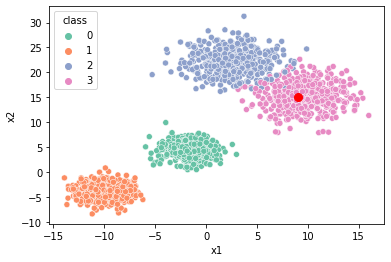

In [6]:
instance2explain = {'x1':9,'x2':15, 'class':3}
#instance2explain = {'x1':4,'x2':20, 'class':0}
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1,cluster_std=1.4)
X2,y2 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=42,cluster_std=2.4)
X2[:,0]+=5
X2[:,1]+=13
X=np.concatenate((X,X2))
y= np.concatenate((y,y2+2))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')
graph.axes.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

### LORE neigh

In [7]:
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

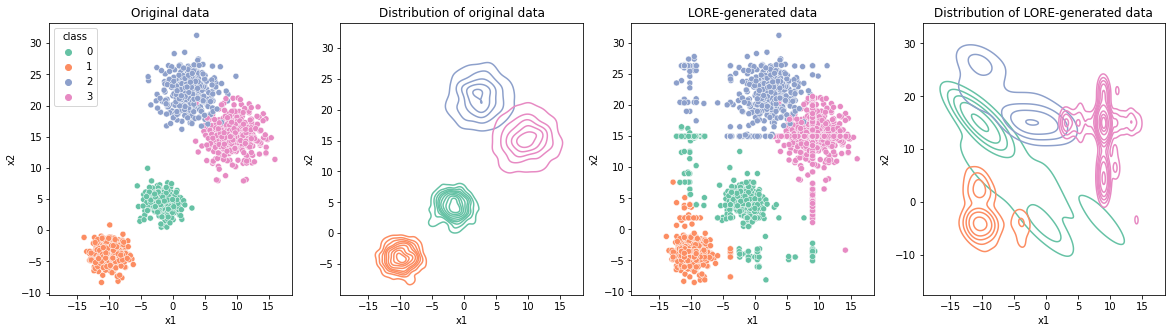

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('LORE-generated data')
axes[3].set_title('Distribution of LORE-generated data')
plt.savefig('./pix/lore-generated-data.pdf', format='pdf',bbox_inches='tight')

In [9]:
X_explain = np.concatenate((np.array(list(instance2explain.values()))[:-1].reshape(1,-1), dataset['X']))
exp_LORE, info_LORE = lore.explain(0, X_explain,
                                   dataset, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path='./EXPLAN/yadt/',
                                   sep=';', log=True, depth=10)

rule_LORE = {} 
for i,v in  exp_LORE[0][1].items():
    rule_LORE[i] = [v]


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1068\n + load time: 0.005739 secs (4.57 MiB/s, 186.09 K rows/s)\n + indexing ... done\n + total time: 0.007294 secs (3.59 MiB/s, 146.42 K rows/s)\nBuilding 1 tree(s) on 1068 cases\n + tree(s) built\n + size: 31 depth: 8 nf: 2 time: 0.01867 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 8 nf: 2 time: 0.001317 secs\n'


In [10]:
exp_LORE

([{'class': 3},
  {'x1': '>2.440639', 'x2': '-1.146152< x2 <=19.787793'},
  [525.0, 2.6]],
 [{'x2': '<=-1.146152'}])

### EXPLAN neigh

In [11]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

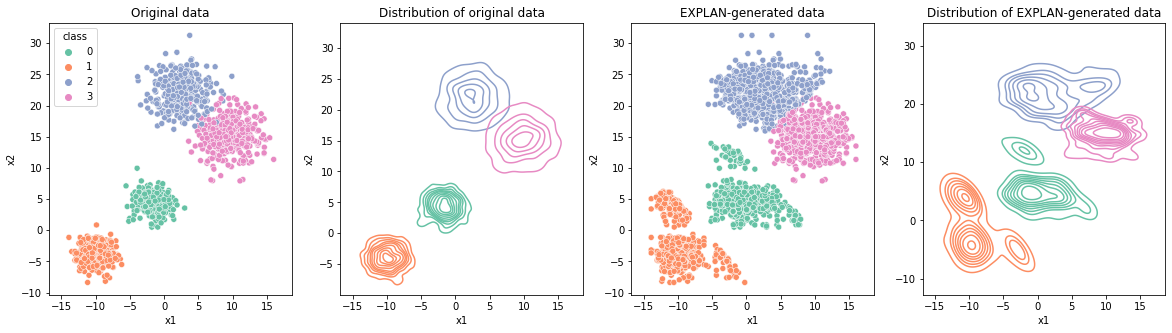

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('EXPLAN-generated data')
axes[3].set_title('Distribution of EXPLAN-generated data')
plt.savefig('./pix/explan-generated-data.pdf', format='pdf',bbox_inches='tight')

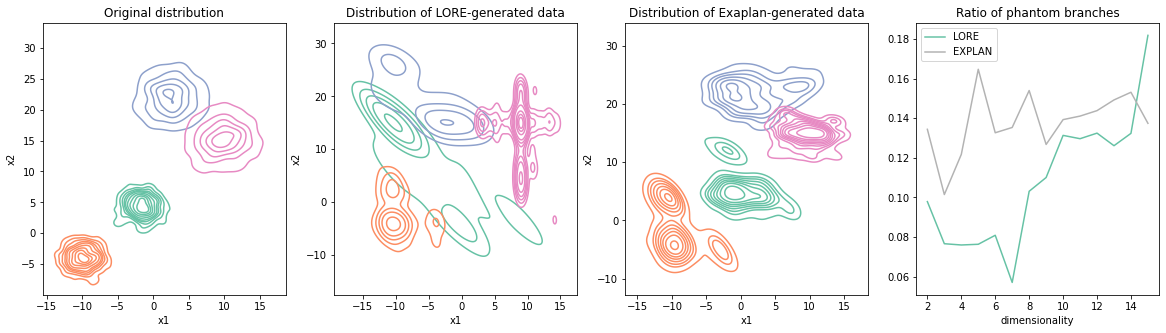

In [13]:
sdf = pd.read_csv('./results/phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
#sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan']].mean().plot(ax=axes[3], cmap='Set2')
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
axes[3].set_title('Ratio of phantom branches')
axes[3].legend(['LORE','EXPLAN'])
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

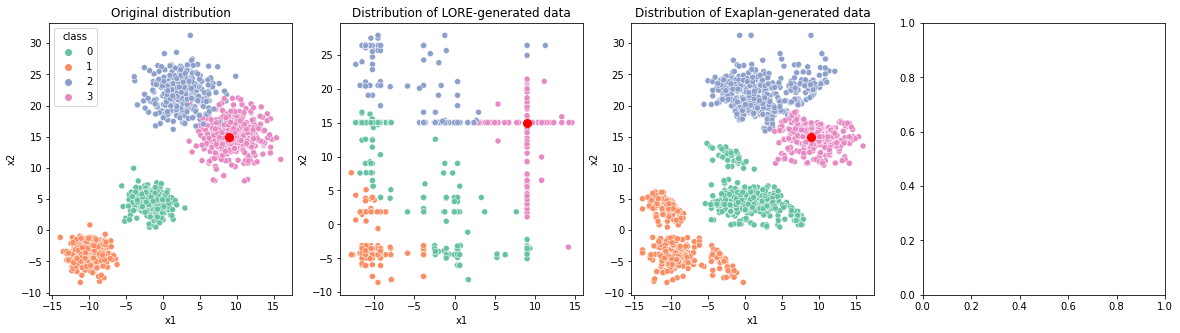

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
#sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
#sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)

instance2explain = {'x1':9,'x2':15, 'class':3}
axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

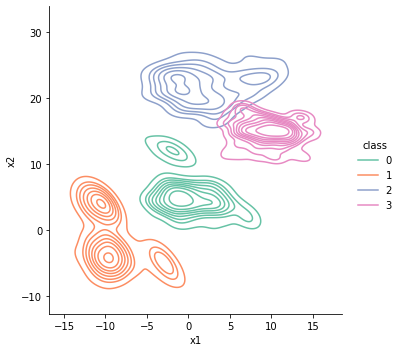

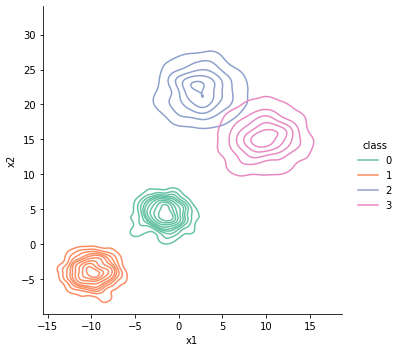

In [15]:
sns.displot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

In [16]:
exp_EXPLAN, info_EXPLAN = explan.Explainer(np.array(list(instance2explain.values()))[:-1],
                                               blackbox,
                                               dataset,
                                               N_samples=3000,
                                               tau=200,depth=10)
rule_EXPLAN = {} 
for i,v in  exp_EXPLAN[1].items():
    rule_EXPLAN[i] = [v]

exp_EXPLAN

./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1320\n + load time: 0.005507 secs (8.91 MiB/s, 239.69 K rows/s)\n + indexing ... done\n + total time: 0.010922 secs (4.49 MiB/s, 120.85 K rows/s)\nBuilding 1 tree(s) on 1320 cases\n + tree(s) built\n + size: 31 depth: 6 nf: 2 time: 0.004352 secs\nPruning tree using training set\n + tree pruned\n + size: 31 depth: 6 nf: 2 time: 2.8e-05 secs\n'


[{'class': 3},
 {'x2': '10.747229< x2 <=17.761678', 'x1': '>4.492216'},
 [316.0, 1.3]]

### LUX neigh

In [17]:
lux = LUX(predict_proba = blackbox.predict_proba, classifier=blackbox,neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=10)
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,
                                         representative='centroid')


(-15.400336008034298, 17.480904720359618)

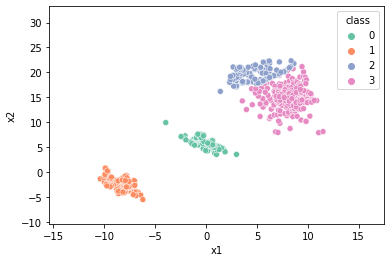

In [18]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette='Set2')
graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

In [19]:
lux.fit(train[features], train[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=True,prune=True,oblique=True,
                                         representative='centroid')


Exact explainer: 773it [00:10,  9.53it/s]                                                                                                                                  


In [20]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 0.8225061311261851 * x1+12.992987768880395 AND x2 >=7.766965627670288 THEN class = 3 # 1.0\n'

## New: upsample according to SHAP

In [21]:
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=False,
                                         representative='centroid')

In [22]:
#calculate shap values
try:
    explainer = shap.Explainer(blackbox,X_train_sample)
    if hasattr(explainer, "shap_values"):
        shap_values = explainer.shap_values(X_train_sample,check_additivity=False)
    else:
        shap_values = explainer(X_train_sample).values
        shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
    if hasattr(explainer, "expected_value"):
        expected_values = explainer.expected_value
    else:
        expected_values=[np.mean(v) for v in shap_values]
except TypeError:
    explainer = shap.Explainer(blackbox.predict_proba, X_train_sample)
    shap_values = explainer(X_train_sample).values
    shap_values=[sv for sv in np.moveaxis(shap_values, 2,0)]
    expected_values=[np.mean(v) for v in shap_values]


if type(shap_values) is not list:
    shap_values = [-shap_values, shap_values]
    expected_values=[np.mean(v) for v in shap_values]
#for each of the samples, perturb it into directino fo the opposite class shap_values


In [23]:
abs(shap_values[0]).sum(0)

array([59.32576022, 75.75022665])

In [24]:
abs(shap_values[1]).sum(0)

array([73.45657991, 67.87852642])

In [25]:
abs(shap_values[2]).sum(0)

array([52.51107505, 98.19483656])

In [26]:
abs(shap_values[3]).sum(0)

array([112.42873939,  78.99673092])

In [27]:
abs_shap=  np.array([abs(sv).mean(1) for sv in shap_values])

In [28]:
abs_shap[:,0]

array([0.40401169, 0.11592305, 0.23638487, 0.21229039])

In [29]:
class_of_i2e = blackbox.predict(ei)
indexer = blackbox.predict(X_train_sample)
shapclass = []

#fit multinomial regression to shap values

for i in range(0,len(X_train_sample)):
    best_index = indexer[i]#[bi for bi in np.argpartition(abs_shap[:,i],2)[-2:] if bi != indexer[i]][0]
    #best_index = [-bi for bi in np.argpartition(abs_shap[:,i],2)[-2:] if bi != indexer[i]][0]
    #vector = np.array([[sv[i,:]]  if ie == best_index else [-sv[i,:] ] for ie,sv in enumerate(shap_values)]).sum(0)
    #shapclass.append(vector)
    shapclass.append([shap_values[best_index][i,:]])
    
shapclass=np.concatenate(shapclass)
shapcols = [c+'_shap' for c in X_train_sample.columns]
cols = [c for c in X_train_sample.columns]
shapdf = pd.DataFrame(shapclass, columns=shapcols)

In [30]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import numdifftools as nd
gradsf = []
gradst = []
for cl in np.unique(indexer):
    gradcl = []
    gradstcl=[]
    for dim in range(0,X_train_sample.shape[1]):
        print(f'Clss {cl}, dim: {dim}')
        mask = indexer==cl
        xs = X_train_sample.iloc[mask,dim]
        ys = shapclass[mask,dim]
        #plt.plot(xs,ys)
        #plt.show()
        grads = np.gradient(ys,xs)
        gradstcl.append(grads)
        svr =LinearRegression()#SVR()
        svr.fit(xs.values.reshape(-1,1),ys)
        #print(svr.coef_)
        print(svr.score(xs.values.reshape(-1,1),ys))
        F=lambda x,svr=svr : svr.predict(x.reshape(1,-1))
        gradient = nd.Gradient(F)
        print(f'Gradient: {gradient([10])}')
        gradcl.append(gradient)
    gradsf.append(gradcl)
    gradst.append(gradstcl)
    

Clss 0, dim: 0
0.876022578388448
Gradient: -0.016855948086536367
Clss 0, dim: 1
0.9896412839225566
Gradient: -0.020485347300947847
Clss 1, dim: 0
0.9570363934783415
Gradient: -0.018174299188037257
Clss 1, dim: 1
0.9130498082167924
Gradient: -0.013564799092285276
Clss 2, dim: 0
0.9379366008300853
Gradient: -0.07210399177812615
Clss 2, dim: 1
0.900158139919691
Gradient: 0.0805453968663487
Clss 3, dim: 0
0.8421382773177958
Gradient: 0.048540274611011486
Clss 3, dim: 1
0.4047598575810645
Gradient: -0.023040422986199245


In [31]:
fulldf = pd.concat([X_train_sample.reset_index(drop=True), shapdf.reset_index(drop=True)],axis=1)
fulldf.index=X_train_sample.index
#fulldf = fulldf[indexer==class_of_i2e]

In [32]:
si2e = np.array(list(instance2explain.values())[:-1])
maxd=np.median(sklearn.metrics.pairwise_distances(X_train_sample, si2e.reshape(1,-1)))

In [ ]:
def perturb(x,num, alpha, gradients,cols, shapcols):
    newx = []
    last = x[cols].values
    newx.append(last)
    cl = blackbox.predict(last.reshape(1,-1))[0]
    grad = np.array([g(last[i]) for i,g in enumerate(gradients[cl])])
   # grad = np.array([g(last[i]) for i,g in enumerate(gradients[cl])])
    for _ in range(0,num):
        if blackbox.predict(last.reshape(1,-1))[0] != cl:
            break
        last =last-alpha*grad
        newx.append(last)
    return np.array(newx)
    

 
upsamples = np.concatenate(fulldf.sample(30).apply(perturb,args=(300,np.array([12,12]),gradsf,cols, shapcols),axis=1).values)

In [ ]:
fulldf[features].max()-fulldf[features].min()/5

In [ ]:
updf = pd.DataFrame(upsamples,columns=cols)


In [ ]:
fulldf[target] = blackbox.predict(fulldf[['x1','x2']])
graph_lux = sns.scatterplot(data=fulldf,x='x1', y='x2', hue='class',palette='Set2')
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
nd.Gradient()

In [ ]:
plt.plot(X_train_sample[indexer==3]['x2'].values,shapclass[indexer==3,1])

In [ ]:
plt.plot(X_train_sample[indexer==3]['x1'].values,shapclass[indexer==3,0])

In [ ]:
plt.plot(X_train_sample[indexer==2]['x2'].values,shapclass[indexer==2,1])

In [ ]:
plt.plot(X_train_sample[indexer==2]['x1'].values,shapclass[indexer==2,0])

In [ ]:
plt.plot(X_train_sample[indexer==1]['x1'].values,shapclass[indexer==1,0])

In [ ]:
plt.plot(X_train_sample[indexer==0]['x1'].values,shapclass[indexer==0,0])

In [ ]:
plt.plot(X_train_sample[indexer==0]['x1'].values,shap_values[0][indexer==0,0])

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
features=['x1','x2']
updf[target] = blackbox.predict(updf[features])
graph_lux = sns.scatterplot(data=updf,x='x1', y='x2', hue='class',palette='Set2')
decision_boundary(blackbox,updf[features].iloc[len(updf)-1], updf[features],updf[target],f1='x1',f2='x2', dec_only=True, ax=graph_lux.axes)
#graph_lux.set_ylim(graph.get_ylim())
#graph_lux.set_xlim(graph.get_xlim())

In [ ]:
sns.displot(data=updf,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

## Example of Greedy algorithm vs SHAP-powered tree (shap-powered tree is less complicated)

In [ ]:
#todo; the iris dataset the complexity as a number of features used
#does it improve the consistency with shap? it does not have to?

## Example of uncertainty incorporation in LUX (explaning why model made predictio when model is uncertain of its decision)

In [ ]:
#the high precision rules and sampling around decision boundary

## Example of data generation  (true paterns visible in the data are hidden) -- NO DATA GENERATION, OR SMART GENERATION THAT DOES NOT CHANGE DISTRIBUTION

### LORE

In [ ]:
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')

In [ ]:

instance2explain = {'x1':1.5,'x2':-0.5, 'class':0}
instance2explain = {'x1':0,'x2':1.5, 'class':0}
#instance2explain = {'x1':0,'x2':1, 'class':0}


# X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.05, random_state=0)
# X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=2, random_state=3,
#                                               n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=2,
#                                               n_classes=2)

X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

In [ ]:
depth = 4
exclf = DecisionTreeClassifier(max_depth=depth)
exclf.fit(Zdf[features], Zdf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

In [ ]:
sns.displot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

In [ ]:
# dtg = Source(tree.export_graphviz(exclf, out_file=None, feature_names=features, filled = True,max_depth=depth))
# display(SVG(dtg.pipe(format='svg')))

### Explan

In [ ]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

In [ ]:
depth = 4
exclf = DecisionTreeClassifier(max_depth=depth)
exclf.fit(Ndf[features], Ndf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

In [ ]:
sns.displot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=train,x='x1', y='x2',hue='class', kind='kde', fill=False, palette='Set2')

### LUX

In [ ]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0,min_samples=50 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

In [ ]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

In [ ]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', hue='class', palette='Set1',ax=graph.axes)

In [ ]:
sns.displot(data=Zdf_lux,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=Zdf_lux_noos,x='x1',y='x2', hue='class', kind='kde', fill=False, palette='Set2')

### Lux on more complex example

In [ ]:
X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf[target] = y
features = [f for f in Xdf.columns if f not in [target]]
train, test = train_test_split(Xdf, test_size=0.33, random_state=42)
blackbox = RandomForestClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
blackbox.fit(train[features], train[target])

In [ ]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', hue='class', palette='Set1',ax=graph.axes)

In [ ]:
sns.displot(data=Zdf_lux,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2')
sns.displot(data=Zdf_lux_noos,x='x1',y='x2', hue='class', kind='kde', fill=False, palette='Set2')

## Branch utilisation (phantom branches)

In [28]:
# generate neigh with lore, explan
# fit uid3, use counterfactual code genration on real data to see how it goes
def get_covered(rule, dataset, features, categorical=None):
    if categorical is None:
        categorical = [False]*len(features)
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical))[i] == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    return covered

def coverage_rules(tree, background_train, background_eval,features):
    rules  = tree.to_dict(reduce=True)

    #filter out rules with class same as not_class
    coever_rules = []
    mingen = None
    numfan = 0
    for rule in rules:
        coever_rules.append(rule)
        #find coverage points from background
        rule['covered'] = len(get_covered(rule['rule'],background_eval, features, None))/len(get_covered(rule['rule'],background_train, features, None))
        #find candidates from background according to counterfactual_representative
        if mingen is None or mingen > rule['covered']:
            mingen=rule['covered']
        if rule['covered'] == 0:
            numfan+=1
    return coever_rules,mingen,numfan,numfan/len(rules)

summary=[]
for f in range(4,50):
    for _ in range(1,10):
        if f > 4:
            f2=int(f/2)
            f3=int(f/3)
            f1=f
        else:
            f1=f2=2
            f3=1
            
        if True:
            X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f1, #random_state=3,
                                                           n_informative=f2, n_redundant=0, n_repeated=0, n_clusters_per_class=f3,
                                                           n_classes=3)
            cols = [f'f_{i}' for i in range(0,X.shape[1])]
            Xdf = pd.DataFrame(X, columns=cols)
            Xdf['class'] = y

            target = 'class'
            features = [f for f in Xdf.columns if f not in [target]]
            train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

            blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
            blackbox.fit(train[features],train[target])
            categorical_indicator = [False]*len(features)

            #train.loc[len(train)] = instance2explain
            idx = random.randint(0, len(train))
            dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

            print('ok')

            Zdf,Z = generate_phantom_data(idx_record2explain=idx, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
                        ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
                        discrete_use_probabilities=True,
                        continuous_function_estimation=True)

            print('okk')

            i2e = train.iloc[idx][features].values
            dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
            # Representative data selection step
            representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = blackbox.predict(Ndf[features])


            lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, 
                      grow_confidence_threshold = 0, min_samples=10 ,oversampling_strategy='importance')
            X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[idx][features].values],X_importances = None, 
                                                 exclude_neighbourhood=False, use_parity=True, 
                                                 inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=False, 
                                                 oversampling=True,
                                                     #oversampling_strategy='both',
                                                 representative='centroid')

            #LORE
            data = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lore = len(uid3.tree.to_dict())
            crgen,mg,numfan,prop = coverage_rules(uid3.tree, Zdf, train,features=features)
            #print(uid3.predict(test))
        

            #EXPLAN
            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_explan = len(uid3.tree.to_dict())
            crgen_ep,mg_ep,numfan_ep,prop_ep = coverage_rules(uid3.tree, Ndf, train,features=features)

            ##LUX
            X_train_sample_c = X_train_sample.copy()
            X_train_sample_c[target] = blackbox.predict(X_train_sample_c)
            data = Data.parse_dataframe(X_train_sample_c)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lux = len(uid3.tree.to_dict())
            crgreal,mr,numfanr,propr = coverage_rules(uid3.tree, X_train_sample_c, train,features=features)
            print(f'Num of features {f} Minimal coverage generated {mg}, minimal coverage real {mr}, proportion of phantom: {numfan}')
            summary.append([f,mg,mg_ep,mr,numfan,numfan_ep,numfanr,prop,prop_ep,propr,rnum_lore, rnum_explan, rnum_lux])
            print('ok')
        #except:
        #    print('Error')
        #    pass
        
    

ok
okk
Index(['f_0', 'f_1'], dtype='object')
1.4065378807679128
1.584962500721156
0.5939268842949035
0.4010709289525637
1.0011111665899977
0.7055338954099432
0.36888887962808264
Num of features 4 Minimal coverage generated 0.0, minimal coverage real 0.0, proportion of phantom: 1
ok
ok
okk
Index(['f_0', 'f_1'], dtype='object')
1.2824611470719833
1.584962500721156
1.0131288184335983
Num of features 4 Minimal coverage generated 0.32509505703422054, minimal coverage real 0.0, proportion of phantom: 0
ok
ok
okk
Index(['f_0', 'f_1'], dtype='object')
1.4990212883515563
1.584962500721156
0.9999992772074968
Num of features 4 Minimal coverage generated 0.0, minimal coverage real 1.8837209302325582, proportion of phantom: 3
ok
ok
okk
Index(['f_0', 'f_1'], dtype='object')
1.2095927917217366
1.584962500721156
1.0575996774780407
Num of features 4 Minimal coverage generated 0.3868312757201646, minimal coverage real 0.0, proportion of phantom: 0
ok
ok
okk
Index(['f_0', 'f_1'], dtype='object')
1.483869

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



0.6162366961948075
0.44825011057427877
0.27451923740383877
0.20844917542826047
0.1281904607467681
0.05503903757283453
1.162758236602116
1.2469226152292532
0.7912804038242001
0.6125768200588948
0.5383426764972449
0.35109537241191013
0.5887312773389103
0.1792560669283215
0.061927388911559245
1.0537317914688453
1.5849570787598524
1.4788953839204275
1.4469068118519082
0.9417512684997322
1.1935556391204134
1.238535653109665
1.2445659687102855
0.28907945973164645
1.560160466152177
1.367223053975989
0.9620863801922737
1.2014461200230289
0.863120568566631
1.5611849774473887
1.3913576346927186
1.0846964966076234
1.5453183479886041
1.4741576805213463
1.284304725767742
1.1081093369870219
0.8524051786494786
1.2583010532952992
1.5745040887385962
1.4670001020436958
0.9309628315300683
1.259918337582449
0.5657094525987453
0.3832399491324757
0.13435001140827504
1.4547563469497047
1.187044608519409
0.9755259511264973
1.1161210359830878
0.9841095278800531
0.8944518845341283
1.039350825031111
1.4107164981

In [31]:
uid3.tree.to_dict()

[{'rule': {'f_18': ['<0.553197979927063'],
   'f_37': ['<-0.5997642576694489'],
   'f_39': ['<-0.9750695824623108'],
   'f_10': ['<-0.1624404415488243'],
   'f_1': ['<0.43545638024806976'],
   'f_47': ['<0.21756581589579582']},
  'prediction': '2',
  'confidence': 0.8},
 {'rule': {'f_18': ['<0.553197979927063'],
   'f_37': ['<-0.5997642576694489'],
   'f_39': ['>=-0.9750695824623108'],
   'f_10': ['<-0.1624404415488243'],
   'f_1': ['<0.43545638024806976'],
   'f_47': ['<0.21756581589579582']},
  'prediction': '0',
  'confidence': 1.0},
 {'rule': {'f_12': ['<-0.5045739710330963'],
   'f_18': ['>=0.553197979927063'],
   'f_37': ['<-0.5997642576694489'],
   'f_10': ['<-0.1624404415488243'],
   'f_1': ['<0.43545638024806976'],
   'f_47': ['<0.21756581589579582']},
  'prediction': '1',
  'confidence': 1.0},
 {'rule': {'f_12': ['>=-0.5045739710330963'],
   'f_18': ['>=0.553197979927063'],
   'f_37': ['<-0.5997642576694489'],
   'f_10': ['<-0.1624404415488243'],
   'f_1': ['<0.43545638024806

In [30]:
print('ok')

ok


In [11]:
print(data)

In [29]:

sdf = pd.DataFrame(summary, columns=['dimensionality','min_cov_lore','min_cov_explan','min_cov_lux','phantom_no_lore','phantom_no_explan',
                                     'phantom_no_lux','phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux',
                                     'rules_lore','rules_explan','rules_lux'])
sdf.to_csv('phantoms-both-novel-shap-no-density-latest.csv',index=False)

In [ ]:
sdf = pd.read_csv('phantoms.csv')

In [ ]:
sdf.groupby('dimensionality')[['phantom_no_lore','phantom_no_explan','phantom_no_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[[ 'rules_lore','rules_explan','rules_lux']].mean().plot()

## Example of oblique necessity (lineary decbound in DT is counterintuitive fro experts) -- DT DOES NOT ALWAYS CAPTURES WHAT MODEL TRIES TO CAPTURE

## Need for visualization of explanations throuhg the lenses of DS (explanation should be backed by data distribution, otherwise it is missing important informaiton)

## Tradeoff between locla/global by selecting the fraction

# Stability among same instance

In [20]:
def generate_lore_dataset(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z

In [ ]:


stab_stats=[]
stability_data=[]
# EXPLAN hyper-parameters
N_samples = 3000#n_neighbors
tau = 250#int(n_neighbors)/len(np.unique(df[target])



for fi in range(20,50):
    depth=fi*2
    X,y= sklearn.datasets.make_classification(n_samples=1000+int(fi*100), n_features=fi, random_state=3,
                                                           n_informative=int(fi/2), n_redundant=0, n_repeated=0, n_clusters_per_class=int(fi/3),
                                                           n_classes=2)
    cols = [f'f_{i}' for i in range(0,X.shape[1])]
    Xdf = pd.DataFrame(X, columns=cols)
    Xdf['class'] = y

    target = 'class'
    features = [f for f in Xdf.columns if f not in [target]]
    train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

    blackbox =MLPClassifier()#GradientBoostingClassifier()# SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
    blackbox.fit(train[features],train[target])

    #train.loc[len(train)] = instance2explain
    idx = 10
    i2e = train.iloc[idx][features].values
    dataset = prepare_ds(train.copy(), name = 'dataset', class_name='class', discrete=[], label_encoder={})
    pos_label = blackbox.predict(np.array(i2e).reshape(1,-1))[0]
    rules_temp=[]
    for _ in range(0,10):
        try:
             ##########################################LUX
            categorical_indicator=[False]*len(features)
            uncertain_entropy_evaluator=UncertainEntropyEvaluator()
            n_jobs=-1
            oblique=True
            rsv=None
    
            lux = LUX(classifier = blackbox,predict_proba = blackbox.predict_proba, oversampling_strategy='both',
                      neighborhood_size=0.2,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 ,min_samples=5)
            X_train_sample, _ = lux.create_sample_bb(train[features], blackbox.predict(train[features]),[np.array(i2e).reshape(1,-1)], 
                                                     categorical=categorical_indicator,
                                                          X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                          use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=True,
                                                         representative='centroid',density_sampling=False,n_jobs=-1)
            lux.attributes_names=X_train_sample.columns
            # lux.fit(train[features], train[target], 
            #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
            #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
            #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )
    
            y_train_sample_proba = lux.predict_proba(X_train_sample)
            hot = np.argmax(y_train_sample_proba,axis=1)
            y_train_sample = np.zeros(y_train_sample_proba.shape)
            for i in range(0,len(y_train_sample)):
                y_train_sample[i,hot[i]] = 1
            #limit features here
    
            #TODO: filter uncertain samples
            
            # threshold_proba = np.max(lux.predict_proba(np.array(i2e).reshape(1,-1)))
            # proball = np.max(lux.predict_proba(X_train_sample), axis=1)
            # threshold = np.min((np.mean(proball) - 2* np.std(proball), threshold_proba))
            # X_train_sample = X_train_sample[proball >= threshold]
            # y_train_sample=y_train_sample[proball >= threshold]
            
            #limit features here
            uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
            udata = Data.parse_uarff_from_string(uarff)
            print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
            lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
            if lux.classifier is not None:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=False,
                                        depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
            else:
                lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,
                                        n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
    
    
            justification_dict = lux.justify(np.array(i2e).reshape(1,-1), to_dict=True)[0][0]
            rule_lux_shap = justification_dict['rule']
            
            cov_lux, acc_lux, prec_lux, rec_lux, f1_lux = coverage_precision(rule_lux_shap, test, features, 
                                                                                            [False]*len(features), pos_label, class_label='class')
            print(f'LUX: {f1_lux}')
             # Explaining instance x using EXPLAN
            # exp_EXPLAN, info_EXPLAN = explan.Explainer(i2e,
            #                                            blackbox,
            #                                            dataset,
            #                                            N_samples=N_samples,
            #                                            tau=tau,depth=depth)
            # rule_EXPLAN = {} 
            # for i,v in  exp_EXPLAN[1].items():
            #     rule_EXPLAN[i] = [v]
    
            # rule_EXPLAN = split_rule_conditions(rule_EXPLAN)
            # #EXPLAN expl e = {'f_2': '0.426178< f_2 <=1.226002', 'f_4': '<=0.608496', 'f_7': '>-0.403450'}
    
            # cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, 
            #                                                                                 [False]*len(features), exp_EXPLAN[0][dataset['class_name']], 
            #                                                                                 class_label='class')
    
    
    
            #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
            myds = dataset
            #myds = prepare_ds(dfneigh_tr,discrete=categorical_indicator)
            X, y = myds['X'], myds['y']
            instance2explain = i2e
            clf=blackbox
    
            # EXPLAN hyper-parameters
            # Explaining instance x using EXPLAN
            # exp_EXPLAN, info_EXPLAN = explan.Explainer(instance2explain,
            #                                            clf,
            #                                            myds,
            #                                            N_samples=N_samples,
            #                                            tau=tau,depth=depth)
    
            dense_samples = DataGeneration(instance2explain, clf, myds, N_samples)
            # Representative data selection step
            representative_samples = DataSelection(instance2explain, clf, dense_samples, tau)
            # Data balancing step
            neighborhood_data = DataBalancing(clf, representative_samples, myds)
    
            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = clf.predict(Ndf[features])
    
            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs)
    
    
            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(np.array(i2e).reshape(1,-1), to_dict=True)[0][0]
            
    
            rule_EXPLAN = justification_dict['rule']
     
    
            cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
    
            print(f'EXPLAN: {f1_EXPLAN}')
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%% LORE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
            # exp_LORE, info_LORE = lore.explain(0, X_explain,
            #                                    dataset, blackbox,
            #                                    ng_function=genetic_neighborhood,
            #                                    discrete_use_probabilities=True,
            #                                    continuous_function_estimation=False,
            #                                    returns_infos=True, path='./EXPLAN/yadt/',
            #                                    sep=';', log=True, depth=depth)
    
            Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,ng_function=genetic_neighborhood, discrete_use_probabilities=True, continuous_function_estimation=False)
                
            datalore = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=depth,node_size_limit=2)
            uid3.fit(datalore,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=n_jobs)
    
            lux = LUX(clf.predict_proba)
            lux.uid3 = uid3
            lux.attributes_names=features
            justification_dict = lux.justify(np.array(i2e).reshape(1,-1), to_dict=True)[0][0]
    
            rule_LORE = justification_dict['rule']
    
            cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE,test, features, categorical_indicator, justification_dict['prediction'], class_label='class')
    
    
            print(f'EXPLAN: {f1_LORE}')
            ############################ ANCHOR ######################################
            X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
            anchor_explainer = fit_anchor(dataset, train[features].values, train[features].values, train[target].values, train[target].values, X_explain)
            exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                        blackbox.predict, threshold=np.max([0.5]+[f for f in [prec_LORE,prec_EXPLAN] if f is not np.nan]))
    
            anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
            ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]
    
    
    
            #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
            #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
            #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
            #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))
    
            rule_Anchor_full = anchor2arule(exp_Anchor)
            rule_Anchor={}
            for i,v in rule_Anchor_full.items():
                if i in ats_anchor[:anch_depth+1]:
                    rule_Anchor[i]=[v]
    
            dfXExplain = build_df2explain(blackbox, X_explain, dataset)
            rule_Anchor = split_rule_conditions(rule_Anchor)
    
            cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, 
                                                                                            [False]*len(features), pos_label, class_label='class')
    
            print(f'EXPLAN: {f1_anchor}')
    
    
            rules_temp.append([np.array(i2e).reshape(1,-1),blackbox.predict(np.array(i2e).reshape(1,-1))[0],rule_EXPLAN, rule_LORE, rule_Anchor,rule_lux_shap])
        except:
            pass





    results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_EXPLAN', 'rule_LORE','rule_ANCHOR','rule_LUX'])
    stab_stats = [stability_stats(results_rules, rid, train, features, [False]*len(features)) for rid in ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX']]
    stability_data.append(['tmp',fi]+list(np.concatenate(stab_stats)))
    print(stab_stats)
    ## save results       

#TODO: coverage, prec/rec/f1, variance as entropy of counts of appearence of variables in explanations

Permutation explainer: 564it [00:26, 13.58it/s]                         


Done 0.43872113676731794 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.682089552238806 samples from train set wiuth class balance: 0.3967906637490883


Permutation explainer: 1372it [00:52, 21.17it/s]                          


0.969042267890948


Permutation explainer: 641it [00:14, 10.39it/s]                         


0.46402292665464645


Permutation explainer: 620it [00:14, 10.42it/s]                         


0.38181808490678637


Permutation explainer: 565it [00:11,  7.07it/s]                         


0.24585774771861915


Permutation explainer: 557it [00:12,  8.49it/s]                         


0.18822088853744873


Permutation explainer: 542it [00:11,  3.90it/s]                         


0.09970084302171917


Permutation explainer: 539it [00:12,  7.41it/s]                         


0.0632623114020632


Permutation explainer: 536it [00:10, 10.03s/it]                 


0.035526692072358465


Permutation explainer: 732it [00:30, 15.18it/s]                         


0.9267171384163062


Permutation explainer: 379it [00:12,  6.37it/s]                         


0.5342081882797987
0.1797973465238472
0.13880049798406022
0.06905438212565047
0.9097361225311662
0.8680403986166403


Permutation explainer: 354it [00:17,  8.13it/s]                         


0.9824170664410183


Permutation explainer: 277it [00:11,  2.99it/s]                         


0.9475052381963255
0.9923628747472766
0.8089250754728767
0.41923299508081996
LUX: 0.9583333333333334
1.0
0.825497840100197
0.5690757032004627
0.4286184934855057
0.3347676126777638
0.21450983370697768
0.3820609539404418
0.7444131797881748
0.9709505944546686
0.228538143953528
0.14981136747274792
EXPLAN: 0.5
0.9991047638704686
0.815397875884013
0.7518972278650766
0.5869790118261127
0.39013062397708376
0.26162296674742214
0.19914574401803517
0.15255409670001127
0.4097202662079565
0.3108777357797976
0.08970338978684994
EXPLAN: 0.6046511627906976
EXPLAN: 0.6271186440677966


Permutation explainer: 564it [00:26, 12.94it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.3897810218978102


Permutation explainer: 1371it [00:49, 22.96it/s]                          


0.9646580888400265


Permutation explainer: 654it [00:13, 10.82it/s]                         


0.4626529147223246


Permutation explainer: 628it [00:13,  8.25it/s]                         


0.3665780125533459


Permutation explainer: 610it [00:11,  5.90it/s]                         


0.30392435096117504


Permutation explainer: 579it [00:11,  4.56it/s]                         


0.20008634077897847


Permutation explainer: 571it [00:12, 10.64it/s]                         


0.13748205971113284
0.048560801924871826


Permutation explainer: 552it [00:10,  1.06it/s]                         


0.019142093640827185


Permutation explainer: 718it [00:28, 16.37it/s]                         


0.9290515247591358


Permutation explainer: 374it [00:14,  9.11it/s]                         


0.5684369300276936
0.18483571570320104
0.9311540951784493
0.8897006746992595


Permutation explainer: 345it [00:14,  6.81it/s]                         


0.9847064898071802


Permutation explainer: 268it [00:11,  3.86it/s]                         


0.9540883068911525
0.97866627341934
0.9956156427297898
0.9043814577244937
LUX: 0.8636363636363636
1.0
0.9568044626915533
0.9798687566511528
0.8554508105601306
0.9927744539878083
0.6728579850233936
0.4770713062193297
0.3359089771530552
0.0715037894499587
0.38705142139219784
0.20687780750472537
0.12311463565031058
EXPLAN: 0.7142857142857143
0.9992871133400469
0.8529652281477911
0.3372900666170139
0.1858030790723033
0.6069842272645694
0.36340985244932567
0.26451736836297474
0.17203694935311378
0.13503620280212764
0.10760938360997835
0.04649154902761415
0.02605073875908456
0.45463902566661496
0.18717625687320816
0.13035034910142979
0.038671790863764946
EXPLAN: 0.75
EXPLAN: 0.7058823529411765


Permutation explainer: 564it [00:24, 13.61it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.39197080291970804


Permutation explainer: 1371it [00:44, 23.92it/s]                          


0.9660596069079856


Permutation explainer: 629it [00:12,  9.00it/s]                         


0.43369992043228844


Permutation explainer: 609it [00:11,  5.35it/s]                         


0.3500105929268849


Permutation explainer: 589it [00:11,  4.60it/s]                         


0.26130665668019293


Permutation explainer: 580it [00:13, 10.02it/s]                         


0.19981952947888357


Permutation explainer: 566it [00:16, 12.60it/s]                         


0.13844881341536314


Permutation explainer: 560it [00:16, 13.21it/s]                         


0.09708553796670966
0.06164920768303981
0.01998996287876639


Permutation explainer: 743it [00:29, 16.51it/s]                         


0.9356230337661806


Permutation explainer: 369it [00:12,  6.04it/s]                         


0.5281098034628294
0.18034223160662136
0.9182958340544896


Permutation explainer: 375it [00:15,  8.48it/s]                         


0.9813541523570553


Permutation explainer: 288it [00:16,  6.79it/s]                         


0.9446323584086029
0.9961812375892514
0.9884783227925917
0.8179252501386403
0.44226151434798167
LUX: 0.875
1.0
0.7219280948873623
0.4750236744443028
0.34422774398506073
0.11759466565886476
0.04961407338355302
0.6990170368314718
0.5283018521097583
0.876716288999464
0.20486591527408562
0.08536734654262206
EXPLAN: 0.5523255813953488
0.9997559518094499
0.8387947764346512
0.4050201326242423
0.6252624052234231
0.2998025130558692
0.2371188605153447
0.18622323058437312
0.10480657173152536
0.07569731106089332
0.042816600068428065
0.9626983787500768
0.4344152792772976
0.21030404308799366
0.10928571467638522
0.06268265300135281
EXPLAN: 0.6944444444444444
EXPLAN: 0.7058823529411765


Permutation explainer: 564it [00:34, 12.07it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.38686131386861317


Permutation explainer: 1371it [00:47, 23.79it/s]                          


0.9627441442359614


Permutation explainer: 654it [00:13, 10.36it/s]                         


0.4626529147223246


Permutation explainer: 630it [00:18, 12.98it/s]                         


0.37165240446153813


Permutation explainer: 573it [00:13, 10.49it/s]                         


0.23519338181924143


Permutation explainer: 565it [00:16, 13.24it/s]                         


0.17702124061159166


Permutation explainer: 552it [00:11,  4.47it/s]                         


0.10944579608881942


Permutation explainer: 543it [00:10,  5.02s/it]                 


0.049460598686410506
0.019509271554984574


Permutation explainer: 718it [00:30, 15.02it/s]                         


0.9341303192311399


Permutation explainer: 353it [00:13,  7.34it/s]                         


0.5107878229540133
0.23519338181924143
0.04256591576655208
0.8308111022361422
0.7434073165779197


Permutation explainer: 366it [00:21,  9.04it/s]                         


0.9823360617557881


Permutation explainer: 272it [00:14,  6.13it/s]                         


0.9499040265089971
0.9993879681484048
0.8551261862366478
LUX: 0.9444444444444444
0.9999940091810504
0.8553820715653824
0.9734911299751576
0.7056366064601749
0.5819569606149722
0.49418293484978865
0.9149263727797274
0.6220403090607189
0.8322765236223413
0.6848735890019694
0.5597404598417696
0.3400904099597863
0.22961838232682963
0.24162730674407812
0.046592181399810535
0.7286000570390021
0.3829576722723534
0.3048187354456775
0.44790785891493196
0.3411538931451762
0.5192300197391869
0.05153928932135066
0.9976554976868683
0.9009026954478969
EXPLAN: 0.8000000000000002
0.9990833600240571
0.8153735448100355
0.9123365412377751
0.7134566956859694
0.6357046999778722
0.37123232664087563
0.49859265611651044
0.288342361440364
0.21871038915724167
0.16142060691402882
0.09539602831657479
0.06293885561144645
0.324848002392721
0.10709694954445004
EXPLAN: 0.6410256410256411
EXPLAN: 0.7272727272727273


Permutation explainer: 564it [00:25, 12.91it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.3905109489051095


Permutation explainer: 1371it [00:50, 22.37it/s]                          


0.965128490303266


Permutation explainer: 656it [00:14, 12.47it/s]                         


0.46657112244942384


Permutation explainer: 632it [00:16, 11.57it/s]                         


0.3766544415054948


Permutation explainer: 611it [00:13, 10.60it/s]                         


0.29675224476927753


Permutation explainer: 581it [00:10,  2.76it/s]                         


0.1909213927693741


Permutation explainer: 574it [00:14, 13.08it/s]                         


0.1268847370465334


Permutation explainer: 564it [00:10,  2.52s/it]                 


0.060920418795428


Permutation explainer: 561it [00:11,  3.74it/s]                         


0.03417642408659739


Permutation explainer: 716it [00:30, 15.00it/s]                         


0.9273389282515145


Permutation explainer: 308it [00:11,  3.06it/s]                         


0.44047991436706463
0.11611507530476972
0.06656103698030306


Permutation explainer: 409it [00:18,  9.86it/s]                         


0.9970686664928682


Permutation explainer: 248it [00:10,  1.93it/s]                         


0.9737216701740783
0.9891228919844623
0.9677884628267678
0.8461487823922604
0.6789538995185758
0.5597404598417696
0.4488644887230294
LUX: 0.8571428571428571
0.9999613413197503
0.762211160337422
0.9313043685793763
0.5784355858047218
0.49078760602503835
0.4284309011062874
0.3095434291503252
0.18843135630402474
0.06405347705857845
0.8429710443954301
0.9774178175281716
0.24047340659188007
0.9995844639313985
0.9208483573869393
0.8598572660241315
0.800189143848444
0.6627631231582569
0.48977901368693755
0.31135737042928313
0.21084230031853213
0.6631968402398287
0.21988771218053432
0.11539039325220715
0.0667796410970523
EXPLAN: 0.8309859154929577
0.9994563557240402
0.9012077414433652
0.17203694935311378
0.07201647168541384
0.7001491080795208
0.4748384883008606
0.37627562807992276
0.24644492338740104
0.21563771533913406
0.17172391115913796
0.11058084476988708
0.04589744461476318
0.02576454913517821
0.49881267017660585
0.3409238906708339
0.28317007247406717
0.21767548390855174
0.1603287258990285

Permutation explainer: 564it [00:23, 13.74it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.3897810218978102


Permutation explainer: 1371it [00:47, 23.11it/s]                          


0.9646580888400265


Permutation explainer: 656it [00:13, 10.84it/s]                         


0.47141072373198933


Permutation explainer: 630it [00:12,  8.13it/s]                         


0.37165240446153813


Permutation explainer: 610it [00:11,  6.10it/s]                         


0.2971117635739131


Permutation explainer: 593it [00:11,  6.32it/s]                         


0.22912597074766633


Permutation explainer: 585it [00:13, 10.58it/s]                         


0.17226730852629657


Permutation explainer: 564it [00:12,  9.84it/s]                         


0.060920418795428


Permutation explainer: 561it [00:13, 10.31it/s]                         


0.03417642408659739


Permutation explainer: 716it [00:28, 17.25it/s]                         


0.9299429352091801


Permutation explainer: 363it [00:12,  5.69it/s]                         


0.5493526097279924
0.1649012192942012
0.12028557152738378
0.9321115676166747


Permutation explainer: 354it [00:14,  7.14it/s]                         


0.9860558974343825


Permutation explainer: 253it [00:10,  2.03s/it]                         


0.9368713342313647
0.9981592324817737
0.7980703919536354
0.4488644887230294
0.9553413768968345
LUX: 0.8636363636363636
0.9999918222756929
0.8590589354860938
0.7412466905234424
0.29892393694554464
0.15838440747285049
0.931196675674717
0.7907067265182695
0.5363596511250623
0.5640381352103987
0.7588840483719563
0.2334897104477296
EXPLAN: 0.6333333333333333
0.9995606104096566
0.6426436485097792
0.4314842789213802
0.31531568742974536
0.2761954276479391
0.24229218908241482
0.205592508185083
0.11190990870168403
0.06648851252976393
0.026827723134058217
0.3893256144515589
0.2959062920385183
0.2184599114008225
0.09249901301652051
0.05363316840061028
EXPLAN: 0.7692307692307693
EXPLAN: 0.7058823529411765


Permutation explainer: 564it [00:30, 12.49it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.39124087591240875


Permutation explainer: 1371it [00:55, 20.64it/s]                          


0.9655956622725492


Permutation explainer: 654it [00:13,  9.27it/s]                         


0.46753757877364094


Permutation explainer: 629it [00:12,  7.58it/s]                         


0.3720735386834666


Permutation explainer: 573it [00:10,  1.53it/s]                         


0.23519338181924143


Permutation explainer: 565it [00:10,  1.44it/s]                         


0.17702124061159166


Permutation explainer: 552it [00:16, 12.70it/s]                         


0.10944579608881942


Permutation explainer: 549it [00:13,  8.43it/s]                         


0.07492880731781656


Permutation explainer: 546it [00:12,  9.37it/s]                         


0.04923229504784486
0.0196034283507716


Permutation explainer: 718it [00:27, 16.28it/s]                         


0.9277508165386218


Permutation explainer: 370it [00:14,  5.85it/s]                         


0.5349436990971066


Permutation explainer: 253it [00:10,  1.06it/s]                         


0.1623261801753929


Permutation explainer: 251it [00:10,  2.05it/s]                         


0.11835001140827503
0.9182958340544896


Permutation explainer: 349it [00:19,  8.83it/s]                         


0.9825606664869173


Permutation explainer: 269it [00:10,  1.94it/s]                         


0.9411864371816836
0.996665728363104
0.8088678222620949
0.39662777277837885
LUX: 1.0
1.0
0.8735609120824457
0.9345275660736608
0.6367368786558287
0.3860189005698934
0.6331913481952375
0.5123521432403346
0.2460225782203316
0.07981182887500551
0.4220005168831531
0.8904916402194913
0.6569796938243497
0.27866980356389914
0.16018811016008405
0.08330599453949258
0.9961812375892514
EXPLAN: 0.7741935483870968
0.9996604153331975
0.8521824570112779
0.1943918578315762
0.6339839699034924
0.3246141810128147
0.21357981533827733
0.14169056800655663
0.0893719289701684
0.04307048235072913
0.34473544633021924
0.15196756454078234
EXPLAN: 0.7692307692307693
EXPLAN: 0.7058823529411765


Permutation explainer: 564it [00:27, 13.16it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.3956204379562044


Permutation explainer: 1371it [00:48, 23.37it/s]                          


0.9683309944732617


Permutation explainer: 641it [00:14, 13.03it/s]                         


0.4590105703102083


Permutation explainer: 618it [00:14, 11.35it/s]                         


0.36477342086086845


Permutation explainer: 599it [00:13, 10.06it/s]                         


0.2871068886681468


Permutation explainer: 590it [00:12,  8.18it/s]                         


0.23001399691659946


Permutation explainer: 575it [00:12,  6.88it/s]                         


0.1654270339962668


Permutation explainer: 552it [00:10,  1.28s/it]                         


0.07459264756085597


Permutation explainer: 549it [00:10,  1.66it/s]                         


0.04900625044373694


Permutation explainer: 538it [00:10,  2.17it/s]                         


0.019571935182123995


Permutation explainer: 731it [00:30, 15.69it/s]                         


0.9271587399898308


Permutation explainer: 369it [00:16,  8.65it/s]                         


0.5122502440025585


Permutation explainer: 262it [00:10,  2.18it/s]                         


0.1781841770505996
0.9119388957757235


Permutation explainer: 363it [00:14,  7.86it/s]                         


0.9838884598998849


Permutation explainer: 271it [00:10,  2.02it/s]                         


0.9451152173024928
0.8536576732793313
0.521016937889524
LUX: 0.8000000000000002
0.9999896107464183
0.47357292491745184
0.1581928138185114
0.047624942129031324
0.9436603930086386
0.6692517540692094
0.4468557686825453
0.27685049564525377
0.1948947808291692
0.1610358865962735
0.35096017303221255
0.19902377455969078
0.9328874510769348
0.9998220335339199
0.9028350359954476
0.77655578544446
0.48833020341885913
0.31166198862303285
EXPLAN: 0.6557377049180327
0.9993558540633997
0.8559406275098069
0.6500224216483541
0.43326099547253494
0.29261136769149376
0.22983578430824558
0.4783411121257288
0.4126486244383498
0.33577155769871303
0.15993568229207536
0.07901358952994919
0.02515798777689061
0.49928910854970593
0.4244051447248036
0.364504909595104
0.3309971512303677
0.25186284771956513
0.22048163357395537
0.17008983515342094
0.13148822893801324
0.04007569957968721
EXPLAN: 0.9166666666666666
EXPLAN: 0.75


Permutation explainer: 564it [00:23, 13.74it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.3875912408759124


Permutation explainer: 1371it [00:45, 25.09it/s]                          


0.9632274856245188


Permutation explainer: 648it [00:15, 11.48it/s]                         


0.445535913442103


Permutation explainer: 624it [00:13, 10.56it/s]                         


0.35009143205776966


Permutation explainer: 607it [00:12,  6.65it/s]                         


0.29128368730918486


Permutation explainer: 589it [00:11,  4.14it/s]                         


0.2141367567812511


Permutation explainer: 581it [00:16, 12.85it/s]                         


0.15478683350100697


Permutation explainer: 562it [00:10,  1.25it/s]                         


0.06110086585229066


Permutation explainer: 559it [00:10,  1.71it/s]                         


0.034280386319742936


Permutation explainer: 724it [00:29, 15.43it/s]                         


0.9327643524565122


Permutation explainer: 315it [00:10,  2.03s/it]                 


0.5676550655260211
0.1222915970693747
0.03950117460432034


Permutation explainer: 410it [00:17,  9.25it/s]                         


0.9994781620418174


Permutation explainer: 265it [00:11,  3.97it/s]                         


0.9393645314754715
0.8509139235120904
0.7306802808071605
0.41083783851692773
0.7219280948873623
0.59728274179791
0.3860189005698934
LUX: 0.8636363636363636
0.9999948704115529
0.6751914401458716
0.28639695711595625
0.14295535512672705
0.9456603046006401
0.9052853757202974
0.9723594643683988
0.6739468651941155
0.5268652118824981
0.6442142137378307
0.3138129641688651
0.19290007457898412
0.08283655281361223
EXPLAN: 0.5968992248062015
0.9998646331239298
0.845163351213219
0.4111664900021256
0.6117885584720008
0.32183715247832606
0.2591738961605754
0.13851379303093775
0.10070888413189642
0.07266863818896668
0.023142453303498133
0.31358499626203346
0.1577024699842573
0.06405347705857845
EXPLAN: 0.7631578947368421
EXPLAN: 0.7058823529411765


Permutation explainer: 564it [00:28, 13.73it/s]                         


Done 0.4369449378330373 upsampling
Done 0.9964476021314387 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19'],
      dtype='object')
In fact using: 0.681592039800995 samples from train set wiuth class balance: 0.38905109489051093


Permutation explainer: 1371it [00:48, 21.70it/s]                          


0.96418445570535


Permutation explainer: 656it [00:14, 13.02it/s]                         


0.46657112244942384


Permutation explainer: 629it [00:15, 13.35it/s]                         


0.3661613004744755


Permutation explainer: 608it [00:12,  6.86it/s]                         


0.2839425079744648


Permutation explainer: 590it [00:11,  3.68it/s]                         


0.205592508185083


Permutation explainer: 582it [00:10,  2.86it/s]                         


0.14509723588112272


Permutation explainer: 564it [00:13, 12.85it/s]                         


0.060920418795428
0.03417642408659739


Permutation explainer: 716it [00:26, 16.56it/s]                         


0.9299429352091801


Permutation explainer: 325it [00:12,  6.19it/s]                         


0.4244051447248036
0.11467550533614673
0.06570187838061435


Permutation explainer: 392it [00:18,  8.27it/s]                         


0.9895518974060279
0.9866967086735614
0.9961344835095796
0.9852281360342515
0.8035184846154338
0.5954670513561874
LUX: 0.8636363636363636
0.9997409348388666
0.8878942566119932
0.7957921552739309
0.9999802266709789
0.9327076126690368
0.7889406572966208
0.5980773161246928
0.7607859931846075
0.6500224216483541
0.5827761991285288
0.4262286569981449
0.38028141940427185
0.5140912790181235
0.4111664900021256
0.2658608862417044
0.20486591527408562
0.13402979616803595
0.046592181399810535
0.7288903745523254
0.21450983370697768
0.12437214415176873
0.9337758589243222
0.9709505944546686
0.8474179614176633
0.7424875695421236
0.445468552077406
EXPLAN: 0.6
0.9992843034724317
0.6863497974172192
0.5032583347756457
0.3147795608178464
0.26377743669413856
0.15138595194073862
0.1101454311248314
0.07949044238393407
0.43007980955771863
0.2342165085869521
0.1551032721030342
0.09339778787292866
0.0741494835779208
0.14144054254182067
0.10327508457163546
0.05909292838573303
EXPLAN: 0.8888888888888888
EXPLAN: 1.0

Permutation explainer: 604it [00:26, 13.84it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.35788024776324845


Permutation explainer: 1454it [00:49, 23.38it/s]                          


0.9409095557818521


Permutation explainer: 565it [00:20, 13.91it/s]                         


0.8458067281714041
0.10327508457163546


Permutation explainer: 343it [00:13,  6.19it/s]                         


0.990109761105445
0.8957162717845599
0.9182958340544896
0.7642045065086203
0.9068801718670694
0.9470622432515328
0.8991045208483788


Permutation explainer: 890it [00:23, 20.19it/s]                         


0.5400012364363471


Permutation explainer: 664it [00:12,  8.45it/s]                         


0.21739612237921943


Permutation explainer: 657it [00:12,  9.51it/s]                         


0.1654270339962668


Permutation explainer: 653it [00:14, 11.68it/s]                         


0.13238838316272514


Permutation explainer: 650it [00:16, 14.59it/s]                         


0.10545940491609888


Permutation explainer: 647it [00:16, 14.88it/s]                         


0.0760346956656914


Permutation explainer: 636it [00:15, 14.59it/s]                         


0.030711916449858788


Permutation explainer: 634it [00:16, 13.94it/s]                         


0.9614670453912635
0.8296071030882031
0.9001749450353606
0.7335379291086666
LUX: 0.8833333333333333
0.9999938686385575
0.6115516951951332
0.548486608843174
0.362051251733998
0.222284830685688
0.15196756454078234
0.9232114295716877
0.8704441104104188
0.7219280948873623
0.5733690468444239
0.857558799850773
0.7902069241886371
0.3045866885214023
0.2381787813806583
0.10160931184917107
EXPLAN: 0.1111111111111111
0.9997779672118906
0.21084230031853213
0.07823246525771237
0.9304963023785229
0.6527215895689277
0.7916097173073637
0.6233785314275008
0.4659693269670646
0.3044965537474703
0.254850842086783
0.19902377455969078
0.10017691121353837
0.05693581437135405
0.02309758099065538
EXPLAN: 0.7177419354838711
EXPLAN: 0.8611111111111112


Permutation explainer: 604it [00:24, 14.68it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.3571920165175499


Permutation explainer: 1454it [00:48, 23.53it/s]                          


0.9403276380756738


Permutation explainer: 551it [00:19, 13.10it/s]                         


0.8453509366224364
0.1292337748458849
0.04175261832615954


Permutation explainer: 327it [00:12,  5.37it/s]                         


0.9921393722193474
0.9151637998567839
0.9369230285991699
0.798659130358246
0.9090221560878149
0.8592759806609698


Permutation explainer: 904it [00:23, 20.35it/s]                         


0.5623077238596307
0.9736680645496201
0.9988141148293563


Permutation explainer: 694it [00:15, 12.19it/s]                         


0.2823991694780252
0.7367680100024783


Permutation explainer: 588it [00:10,  1.17it/s]                         


0.14392029811532822


Permutation explainer: 581it [00:12,  9.64it/s]                         


0.08307055395256943
0.046931038257253185
LUX: 0.5
0.9999899940813596
0.8030151028048502
0.9986359641585718
0.9621461334087001
0.4959690720618337
0.34612420094860763
0.0989590953557431
0.6193821946787638
0.9129738498785998
0.42777388975353636
0.32714749707465596
0.4770713062193297
0.3424637724817959
0.14144054254182067
0.998307229542005
0.4520861986745137
0.9600042072840912
0.7437324568563772
0.6019089517362489
0.42048595596815697
0.31319504711541096
0.9111178649415465
EXPLAN: 0.8139534883720931
0.9997400979703274
0.8880260876154067
0.6987003526563343
0.5982548904337475
0.3095434291503252
0.2067783098654222
0.11587241357922297
0.06648851252976393
0.6098403047164004
0.8371496928899813
0.9897148052727835
EXPLAN: 0.631578947368421
EXPLAN: 0.8260869565217391


Permutation explainer: 604it [00:26, 14.82it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.3558155540261528


Permutation explainer: 1454it [00:48, 23.88it/s]                          


0.9391548715400072


Permutation explainer: 549it [00:19, 13.30it/s]                         


0.8467558009336027
0.10403469105822565


Permutation explainer: 329it [00:15,  7.57it/s]                         


0.9922351136028223


Permutation explainer: 214it [00:10,  1.16s/it]                         


0.9086185980409245
0.9311170667175546
0.7886983595248671
0.90626268051371
0.866725613094959


Permutation explainer: 906it [00:25, 19.25it/s]                         


0.5615150663806119


Permutation explainer: 679it [00:18, 15.33it/s]                         


0.23466625778187344


Permutation explainer: 672it [00:16, 18.52it/s]                         


0.1858747992492287


Permutation explainer: 668it [00:13, 10.21it/s]                         


0.15519495194501923


Permutation explainer: 665it [00:12,  9.54it/s]                         


0.13047571663711086


Permutation explainer: 662it [00:16, 16.07it/s]                         


0.10390724581685452


Permutation explainer: 659it [00:14, 10.39it/s]                         


0.07489129415623012


Permutation explainer: 618it [00:11,  5.78it/s]                         


0.9763382628222435
0.8037159237834125
0.8675071344816212
0.7136036068604936
0.6193821946787638
LUX: 0.7804878048780488
0.9997647945905688
0.7471329207109215
0.9822012409694036
1.0
0.9476077999667663
0.8939563962625152
0.5824367288534463
0.404179948491268
0.3420595454486417
0.21691796995839516
0.17117909327394726
0.1370994788998177
0.0840210912413749
0.9596868937742169
0.9629268613452578
0.8452269783079619
0.9337044887280269
0.763545535317125
0.6411642062564138
0.7931659014150266
0.7544062039636578
0.6958774141459803
0.35335933502142136
0.1851247601005459
0.10865045858255667
0.8285885285451822
0.7905013842153698
0.69287851503822
0.4663703330651825
0.3665780125533459
0.2704505135124657
0.33577155769871303
0.25593004383911305
0.12969646470659638
0.07526826758743452
0.9995811192664474
0.9418285354475157
0.9752226909310862
0.8042522359016422
0.6877695785043221
0.584238811642856
0.48660406208078877
0.19745300438456018
0.830130022732297
0.8840358502345849
0.7963725547369538
0.6452227300087223

Permutation explainer: 604it [00:27, 14.35it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.3551273227804542


Permutation explainer: 1454it [00:51, 22.67it/s]                          


0.9385640175811845


Permutation explainer: 796it [00:32, 16.83it/s]                         


0.9663642171368749
0.21856420021263656
0.07442578992239543


Permutation explainer: 567it [00:21, 14.01it/s]                         


0.9960243373731155
0.854864096781804
0.8926230133850986
0.9140185106642175
0.8754720736501888
0.8955333601137407


Permutation explainer: 381it [00:14,  8.24it/s]                         


0.9217647116941612
0.6875275980728325
0.5866942528222021
0.43456735838426486
0.38431154412649704


Permutation explainer: 212it [00:10,  2.54s/it]                 


0.9953124242193561
0.9632599538968548
0.8708644692353644
0.7985237652450763


Permutation explainer: 659it [00:11,  7.24it/s]                         


0.28704218838989987


Permutation explainer: 613it [00:10,  2.66it/s]                         


0.17466817243865132


Permutation explainer: 607it [00:10,  2.76it/s]                         


0.12131966145261767


Permutation explainer: 604it [00:10,  3.36s/it]                 


0.09127800176766096


Permutation explainer: 601it [00:10,  1.08it/s]                         


0.05777796017013378
0.017861094136750987
LUX: 0.4375
1.0
0.40379715049939247
0.17290430438335416
0.9316156826907673
0.9972416209717226
0.9563722682941759
0.7781655393133492
0.46429339352149634
0.2087072820923857
0.14219353322292672
EXPLAN: 0.8636363636363636
0.9995181147462242
0.3650551896402848
0.145136830401354
0.0730661193138456
0.04128046811908642
0.8786744932173093
0.7134566956859694
0.8786744932173093
0.6555020244275949
0.5381411852224502
0.3837461418639162
0.28593604868394695
0.2115647191317121
0.13230746462586215
0.06230254712077371
0.024735664911503773
EXPLAN: 0.7659574468085105
EXPLAN: 0.9111111111111111


Permutation explainer: 604it [00:30, 13.35it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.35650378527185134


Permutation explainer: 1454it [00:58, 21.03it/s]                          


0.9397427441804951


Permutation explainer: 561it [00:24, 13.26it/s]                         


0.8559369864579016
0.10252745273764936


Permutation explainer: 337it [00:12,  5.71it/s]                         


0.9949848281859701
0.9182958340544896
0.9399811758962497
1.0
0.7219280948873623
0.9099503053612785
0.946343998170766


Permutation explainer: 894it [00:23, 20.06it/s]                         


0.5540811442277621


Permutation explainer: 665it [00:15, 14.89it/s]                         


0.21714537205185802


Permutation explainer: 658it [00:14, 13.45it/s]                         


0.16522942275366445


Permutation explainer: 654it [00:12,  7.23it/s]                         


0.13222665414785972


Permutation explainer: 651it [00:13, 11.44it/s]                         


0.10532813038413406


Permutation explainer: 648it [00:12,  7.53it/s]                         


0.07593796785504245


Permutation explainer: 636it [00:13, 13.76it/s]                         


0.030711916449858788


Permutation explainer: 634it [00:12,  7.34it/s]                         


0.9719631971675232
0.8088678222620949
0.8822080503241865
0.7444131797881748
0.665580063146735
LUX: 0.8833333333333333
1.0
0.6071716548713029
0.296426244841378
0.05909292838573303
0.9078426847504951
0.4885001607588282
0.3975411832719274
0.20883932482892928
0.9631672450918831
0.780183978106127
EXPLAN: 0.5
0.998881620087174
0.6255100032026453
0.21544882762652257
0.15862461647089135
0.09362545803956356
0.9023932827949788
0.9076035191206318
0.7087219333311525
0.5366979941964627
0.3417139066676166
0.24229218908241482
0.17688776111821142
0.09734034199573639
0.06425462540840808
0.02570811607372532
0.3733433210798535
0.2829047929798921
EXPLAN: 0.7954545454545455
EXPLAN: 0.9111111111111111


Permutation explainer: 604it [00:27, 15.07it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.35788024776324845


Permutation explainer: 1454it [00:49, 23.34it/s]                          


0.9409095557818521


Permutation explainer: 567it [00:19, 13.64it/s]                         


0.8469372945798002
0.10327508457163546


Permutation explainer: 345it [00:13,  6.50it/s]                         


0.9902246902198684
0.9073226451896848
0.7553754125614287
0.5538976334852962
0.9311540951784493
0.964078764808229


Permutation explainer: 888it [00:22, 19.94it/s]                         


0.5376004546167997


Permutation explainer: 675it [00:15, 14.04it/s]                         


0.23572312756033736


Permutation explainer: 668it [00:14, 13.41it/s]                         


0.18674021561537218


Permutation explainer: 664it [00:13,  9.73it/s]                         


0.15593269087674375


Permutation explainer: 661it [00:13,  8.92it/s]                         


0.13110652958234503


Permutation explainer: 658it [00:14, 14.95it/s]                         


0.10441907800540785


Permutation explainer: 655it [00:13, 11.35it/s]                         


0.07526826758743452


Permutation explainer: 619it [00:11,  3.88it/s]                         


0.9645871390263365
0.8833299633000766
0.7717094696953632
LUX: 0.7631578947368421
0.9999761741481223
0.7591262224200805
0.6084534218491124
0.49531792269264796
0.3768789825574349
0.25943216905006733
0.1890851792749046
0.13620682741246032
0.0730661193138456
0.029717664067347795
0.5252312427545441
0.9238422284571814
0.24005795987567086
0.18312206830137276
0.4394969869215134
EXPLAN: 0.622093023255814
0.9991725952865611
0.16725812083478725
0.07125039973106433
0.8685599449344361
0.6037242656780433
0.406526097422468
0.31852396540847405
0.21877925860379044
0.17896608912302017
0.10271325407997653
0.07401216205406
0.024735664911503773
0.5967435150747518
0.4525863981152221
EXPLAN: 0.625
EXPLAN: 0.74


Permutation explainer: 604it [00:24, 14.59it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.3558155540261528


Permutation explainer: 1454it [00:45, 25.12it/s]                          


0.9391548715400072


Permutation explainer: 553it [00:20, 13.81it/s]                         


0.8490544242540479
0.10403469105822565


Permutation explainer: 333it [00:12,  5.36it/s]                         


0.9924214194347506


Permutation explainer: 224it [00:11,  2.09it/s]                         


0.9074751656515452
0.9305861291319928
0.7841942774499948
0.5721084472041879
0.873298419882363
0.819264971231439


Permutation explainer: 902it [00:24, 22.23it/s]                         


0.5570423524421938


Permutation explainer: 678it [00:13, 12.30it/s]                         


0.2280236021524995


Permutation explainer: 671it [00:15, 12.99it/s]                         


0.17842115611435247


Permutation explainer: 667it [00:13,  9.77it/s]                         


0.14713553603902635


Permutation explainer: 664it [00:13, 10.51it/s]                         


0.12184770813118084


Permutation explainer: 661it [00:13,  8.02it/s]                         


0.09454834067208458


Permutation explainer: 658it [00:15, 15.48it/s]                         


0.06449781445764265


Permutation explainer: 645it [00:12,  8.38it/s]                         


0.01672747086016023


Permutation explainer: 643it [00:11,  6.55it/s]                         
Permutation explainer: 225it [00:10,  5.04s/it]                 


0.9768740126265281
0.8087445300360541
0.8704441104104188
0.7259501452943734
LUX: 0.8840579710144928
0.9998260636859444
0.7319085930137652
0.5733690468444239
0.3502178261776423
0.2718188297480972
0.1654270339962668
0.11327430349709672
0.7194748553156314
0.3957667204933058
0.1667041376275431
EXPLAN: 0.574468085106383
0.9996862702709717
0.6140419804242598
0.09947705087439423
0.8247881345013224
0.9857436088270684
0.873066222275865
0.7197723375750572
0.5218666985479589
0.40517089029803244
0.26496353609662915
0.12741851179235877
0.0649351035202193
0.0264630355906853
0.5836753280239111
EXPLAN: 0.7096774193548389
EXPLAN: 0.74


Permutation explainer: 604it [00:24, 14.63it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.3551273227804542


Permutation explainer: 1454it [00:45, 25.17it/s]                          


0.9385640175811845


Permutation explainer: 562it [00:25, 13.14it/s]                         


0.8350756295065682
0.10365337249761515


Permutation explainer: 341it [00:16,  8.26it/s]                         


0.9855748273706861


Permutation explainer: 224it [00:10,  1.31it/s]                         


0.8924993851906704
0.9150729603584474
0.7612401496918492
0.9266067073697131
0.9590550044058673


Permutation explainer: 893it [00:25, 18.57it/s]                         


0.5194844689580872


Permutation explainer: 667it [00:21, 16.66it/s]                         


0.21664577959201084


Permutation explainer: 660it [00:17, 17.33it/s]                         


0.16483575019489521


Permutation explainer: 656it [00:13, 10.00it/s]                         


0.131904488362944


Permutation explainer: 653it [00:12,  8.07it/s]                         


0.105066646125478


Permutation explainer: 650it [00:12,  7.03it/s]                         


0.07574531010052979


Permutation explainer: 639it [00:14, 15.60it/s]                         


0.030588852697706375


Permutation explainer: 637it [00:12,  8.30it/s]                         


0.9413529965487271
0.7847791991145501
0.8589810370425963
0.7292739418449411
LUX: 0.8833333333333333
1.0
0.8013181968091911
0.4997580164034803
0.38431154412649704
0.22912597074766633
0.4073778911768843
0.9701265835492238
0.7769223946970163
0.48726869433247877
0.9147088431405324
0.17608207264451325
0.11397020802905504
0.06528122535903776
0.992563136012236
EXPLAN: 0.5384615384615384
0.9996875128534535
0.8451317015599205
0.7157073077101314
0.5649654616761693
0.30726835986075973
0.256051869249728
0.17449000776287532
0.07218914045963785
0.028825837116181995
0.7386650272701814
0.1278670878097346
0.04341407633805841
0.9861260846302383
0.9749758483079306
0.9099503053612785
0.7962699368824384
0.6032154068313578
EXPLAN: 0.9047619047619048
EXPLAN: 0.8888888888888888


Permutation explainer: 604it [00:29, 14.10it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.3551273227804542


Permutation explainer: 1454it [00:52, 22.92it/s]                          


0.9385640175811845


Permutation explainer: 558it [00:21, 13.41it/s]                         


0.8481084204572655
0.13110652958234503
0.0429008690735602


Permutation explainer: 338it [00:14,  6.66it/s]                         


0.990317500279016
0.9151637998567839
0.9369230285991699
0.7918583525674836
0.9432261548473415
0.9731560354421095


Permutation explainer: 897it [00:27, 17.50it/s]                         


0.5435644431995964
0.9703853509076517
0.9996911966261435


Permutation explainer: 689it [00:13, 11.78it/s]                         


0.25206971617156637


Permutation explainer: 678it [00:15, 12.76it/s]                         


0.19209027611632934


Permutation explainer: 666it [00:16, 17.51it/s]                         


0.15556286259996746


Permutation explainer: 617it [00:11,  5.33it/s]                         


0.07906626667058542


Permutation explainer: 614it [00:10,  3.92it/s]                         


0.04460329420168675


Permutation explainer: 611it [00:11,  4.95it/s]                         


LUX: 0.6071428571428571
1.0
0.9153699714281696
0.7177418091697444
0.5566343937743038
0.36000350990713337
0.21832103023746735
0.9920854150221708
0.9318316196407056
0.8374782779405223
0.785319810103502
0.8661804490284502
0.9929042710341393
0.6692333986015296
0.7976464081908226
0.941423108186979
EXPLAN: 0.8181818181818182
0.9997258821476676
0.6252624052234231
0.8480976264925242
0.946083697762694
0.9991983542636398
0.04893139830501121
0.8099763882013546
0.5644601304672641
0.42140407020983994
0.35335933502142136
0.26590378498053097
0.23789884139282008
0.16926390283642534
0.14503129755002228
0.09426940448576956
0.04649154902761415
EXPLAN: 0.7857142857142857
EXPLAN: 0.9111111111111111


Permutation explainer: 604it [00:24, 14.62it/s]                         


Done 0.43283582089552236 upsampling
Done 0.9767827529021559 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20'],
      dtype='object')
In fact using: 0.699566682715455 samples from train set wiuth class balance: 0.35443909153475567


Permutation explainer: 1454it [00:56, 21.46it/s]                          


0.9379701797142094


Permutation explainer: 797it [00:27, 18.02it/s]                         


0.9668436669411513
0.2329278554698122


Permutation explainer: 560it [00:21, 13.90it/s]                         


0.9944502859275215
0.869137580612638
0.7855602922535472


Permutation explainer: 374it [00:18,  9.37it/s]                         


0.9146796612143577
0.5617526078313282


Permutation explainer: 260it [00:12,  4.29it/s]                         


0.9800246356721078


Permutation explainer: 220it [00:10,  1.40it/s]                         


0.9313893784092913
0.8112781244591328
0.7473944462440387
0.8323322690121193


Permutation explainer: 658it [00:16, 15.71it/s]                         


0.2808755310705703


Permutation explainer: 651it [00:11,  8.05it/s]                         


0.23519338181924143


Permutation explainer: 642it [00:12,  8.63it/s]                         


0.18467556384196296


Permutation explainer: 633it [00:11,  5.95it/s]                         


0.12661166374683513


Permutation explainer: 630it [00:12, 10.71it/s]                         


0.09831984192711282


Permutation explainer: 627it [00:12, 10.19it/s]                         


0.06713265838732164


Permutation explainer: 624it [00:11,  5.67it/s]                         


0.031214976531355024


Permutation explainer: 621it [00:10,  1.35it/s]                         


LUX: 0.5555555555555556
0.9999821452316464
0.8083730252788988
0.6182649047314496
0.4021791902022728
0.1936428046838986
0.05652459308466933
0.7807072744360741
0.40855348833454974
0.16082302082246938
0.053092652126686124
0.9823576393378013
0.8485481782946158
0.5625393752025973
EXPLAN: 0.78125
0.9990181510783075
0.873646639319215
0.6880476235340796
0.7295938841769811
0.6521560797569468
0.4977354009374426
0.39662777277837885
0.2809512361759036
0.25164107326284196
0.23098464182857795
0.20931241280367252
0.1077744931343512
0.05269490852504428
0.5993142373098092
0.8269207748342082
0.49123734182433315
0.2761954276479391
0.16622269478192106
EXPLAN: 0.6666666666666666
EXPLAN: 0.8260869565217391
[(0.24073380378884918, 0.2750182602206811, 0.3239696969696969, 0.26366540068002764), (0.4914536002453598, 0.208463899162522, 0.6227000222000222, 0.19411137143824556), (0.7314578119987166, 0.17844719305239043, 0.7626666666666666, 0.17621199353808661), (0.6881263551439109, 0.18954597631966327, 0.80384126984

Permutation explainer: 694it [00:30, 14.68it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.23941176470588235


Permutation explainer: 1701it [01:10, 20.69it/s]                          


0.7940606954774044


Permutation explainer: 752it [00:28, 16.83it/s]                         


0.9997122097562967


Permutation explainer: 325it [00:15,  8.79it/s]                         


0.9813387358307915
0.9940302114769565
0.9876061943422965
0.9958269063289604
0.9999656906901914
0.9986746700955949
0.9738959645539289
0.9286751810936651
0.7642045065086203
0.837602456861142


Permutation explainer: 428it [00:17, 11.05it/s]                         


0.9945770323353129


Permutation explainer: 288it [00:13,  5.32it/s]                         


0.9945196118885216
0.5243952392403632
0.9590550044058673
0.9965663713274553
0.9971803988942642
0.853496971990974
0.7863680179953898


Permutation explainer: 950it [00:27, 19.43it/s]                         


0.17019005282120778
0.7990485210442682
0.6587435307694673


Permutation explainer: 851it [00:20, 22.22it/s]                         


LUX: 0.6363636363636364
0.9999714666241031
0.7939772001130361
0.5472469471683307
0.4462660856829299
0.12508296719847556
0.6500224216483541
0.4586858162005403
0.3424637724817959
0.13402979616803595
0.9978683156711936
0.941423108186979
0.5159469300074474
0.7531979910695014
0.9242909795281409
0.1654270339962668
0.04961407338355302
EXPLAN: 0.6862745098039216
0.9976292950461071
0.41148768810159675
0.22934726725290067
0.1626305209975643
0.0985489356909133
0.20062232431271465
0.10000094301032347
0.05777796017013378
0.25424875152237947
0.04074392246859817
EXPLAN: 0.6428571428571429
EXPLAN: 0.763888888888889


Permutation explainer: 694it [00:36, 13.14it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.27941176470588236


Permutation explainer: 1701it [01:00, 23.55it/s]                          


0.8546480601169081


Permutation explainer: 755it [00:34, 15.69it/s]                         


0.9704832033938435


Permutation explainer: 445it [00:19, 11.11it/s]                         


0.9929042710341393


Permutation explainer: 302it [00:12,  4.50it/s]                         


0.9444339905831343


Permutation explainer: 294it [00:11,  3.73it/s]                         


0.9354322131841879
0.894329906939531
0.8431619569518378
0.8246578332945033
0.6840384356390417
0.9456603046006401
0.9794116346561963


Permutation explainer: 311it [00:11,  3.03it/s]                         


0.9105843460392835
0.2904417071791297
0.058758157105190834
0.9661773513883509
0.9999435071707974
0.9937811379408326


Permutation explainer: 947it [00:21, 25.80it/s]                         


0.15935006268563445
0.77655578544446


Permutation explainer: 851it [00:16, 22.55it/s]                         


LUX: 0.6363636363636364
1.0
0.6695382351116196
0.3818578036654199
0.26377743669413856
0.15649106290570153
0.9718300042232968
0.9987979209581139
0.6203226127440906
0.4715814702018223
0.31526533955784414
0.190349134627255
0.04051853381938455
EXPLAN: 0.6666666666666666
0.99835087145734
0.37070870868542466
0.22336082416312036
0.5190356256549793
0.37699386274929547
0.26676498780302604
0.1623261801753929
0.07001205049536138
0.2261895704395554
0.04000290287821209
EXPLAN: 0.5789473684210527
EXPLAN: 0.763888888888889


Permutation explainer: 694it [00:35, 13.21it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.28294117647058825


Permutation explainer: 1701it [01:08, 21.70it/s]                          


0.8594274828842237


Permutation explainer: 751it [00:29, 16.64it/s]                         


0.9677451727749171


Permutation explainer: 440it [00:21, 11.46it/s]                         


0.9909943925273437


Permutation explainer: 280it [00:11,  2.60it/s]                         


0.9959094138937685
0.9996894856846348
0.9986822133734737
0.9899303926829206
0.9999233329473267
0.8571484374283715
0.7905013842153698


Permutation explainer: 312it [00:13,  5.62it/s]                         


0.9094816432244384
0.2616883425284311
0.9619153461563997
0.8346482851813828


Permutation explainer: 951it [00:22, 26.00it/s]                         


0.18641063615992773
0.8414646362081757


Permutation explainer: 851it [00:16, 22.76it/s]                         


LUX: 0.6363636363636364
1.0
0.7848121753536674
0.4325363339391132
0.2885385136944104
0.2333361806939476
0.35804220385316055
0.26806843059535923
0.21084230031853213
0.06425462540840808
0.985909442028652
0.9529596446519792
0.8516458330898722
0.7990485210442682
0.5363596511250623
0.419921097375718
0.6661833101638291
0.4854607607459134
0.7066477892488323
0.4579685237376072
0.25146396423889
0.07642429309554775
0.1101454311248314
EXPLAN: 0.7666666666666667
0.9975708712684204
0.4009961784858501
0.16032872589902852
0.053907905965376854
0.8952722642402939
0.3809465857053901
0.0806607843602246
0.03813932218627321
EXPLAN: 0.7105263157894737
EXPLAN: 0.763888888888889


Permutation explainer: 694it [00:32, 14.12it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.26294117647058823


Permutation explainer: 1701it [00:58, 23.94it/s]                          


0.8311522941313969


Permutation explainer: 691it [00:29, 15.04it/s]                         


0.9700965071720021


Permutation explainer: 441it [00:20, 11.51it/s]                         


0.9906649266228326


Permutation explainer: 273it [00:11,  3.50it/s]                         


0.9923424046435223
0.9999381551930626
0.9988903767411548
0.9962271482775464
0.997799733753238
0.9931709253809187
0.986479814863779
0.9997114417528099
0.8383729377099397
0.7674044165839726
0.465502449081513


Permutation explainer: 251it [00:10,  1.42it/s]                         


0.9043814577244937
0.24832244463628722
0.9807983646944296
0.9953251070631713


Permutation explainer: 1011it [00:26, 25.35it/s]                          


0.20276387413095456
0.8238116333123173
0.5879303728017198
0.4553595475852388


Permutation explainer: 887it [00:20, 26.09it/s]                         


LUX: 0.6666666666666666
0.9999550401999675
0.6607035307414597
0.9366673818775626
0.06425462540840808
0.9284193347653005
0.9075941654188298
0.7812812090702046
0.6209181358912584
0.3784654279151717
0.31166198862303285
0.7007495497162062
0.5412664421908895
0.37627562807992276
0.2595615190860121
0.05256375109324406
EXPLAN: 0.7727272727272727
0.9983572907319185
0.34151002953083176
0.19019536161330802
0.1247975754927794
0.09930374457114824
0.05221741470535915
0.02060130847341223
EXPLAN: 0.5743243243243243
EXPLAN: 0.763888888888889


Permutation explainer: 694it [00:32, 15.20it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.2788235294117647


Permutation explainer: 1701it [00:57, 24.61it/s]                          


0.8538428302823153


Permutation explainer: 763it [00:37, 14.87it/s]                         


0.9748027561984682


Permutation explainer: 433it [00:17, 10.74it/s]                         


0.998128411854084
0.9887964533130849
0.9224062617590723
0.8803968110001441
0.828643675022336
0.9520890193411204
0.8346482851813828
0.9068801718670694


Permutation explainer: 331it [00:14,  6.83it/s]                         


0.8136707627209366


Permutation explainer: 233it [00:11,  2.77it/s]                         


0.42368057157091055
0.9402859586706311


Permutation explainer: 939it [00:27, 23.20it/s]                         


0.16041834971492758


Permutation explainer: 858it [00:20, 23.64it/s]                         


0.0237670051321761


Permutation explainer: 852it [00:21, 23.84it/s]                         


LUX: 1.0
0.9999849596541528
0.6566519379319329
0.994581653424978
0.869137580612638
0.4233708789736443
0.2835690262814882
0.44162013157909064
0.12565805017256743
0.051791350304557005
0.7397414487232901
0.8634779743956251
0.9364537523535492
0.5947936590297476
0.38861174916944274
0.28221763445592507
0.0857426825355025
0.9919270464052614
0.9305861291319928
0.6781944925225872
0.5164909399797735
0.4508933117175976
0.37625125171990126
0.5974359571347753
0.3939152573634121
0.34327541512254434
0.24890486008923207
0.20143225630881323
0.12394986771100759
0.1155345395163905
0.05652459308466933
0.9617779752980335
0.8020771588818674
0.5836753280239111
EXPLAN: 0.9583333333333334
0.9965834803132991
0.6265691797086059
0.8524051786494786
0.6463587189133673
0.5148156530047155
0.670294946400306
0.5736665363828041
0.5140912790181235
0.3984592740952357
0.18255858351701265
0.3038396666465523
0.04074392246859817
EXPLAN: 0.7123287671232877
EXPLAN: 1.0


Permutation explainer: 694it [00:35, 14.99it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.2782352941176471


Permutation explainer: 1701it [01:04, 21.94it/s]                          


0.8530351178521709


Permutation explainer: 754it [00:35, 14.88it/s]                         


0.9692158636821422


Permutation explainer: 399it [00:15,  9.34it/s]                         


0.98765112455122


Permutation explainer: 343it [00:17,  8.50it/s]                         


0.9970129836047847


Permutation explainer: 324it [00:13,  5.61it/s]                         


0.992457324464252


Permutation explainer: 255it [00:10,  2.28it/s]                         


0.9998210980620844
0.9903070204513953
0.9935704757706079
0.9671463157308773
1.0


Permutation explainer: 356it [00:14,  7.38it/s]                         


0.7385108621705726
0.9692040949598235
0.4408744505329845


Permutation explainer: 948it [00:22, 24.50it/s]                         


0.14179613158896046
0.7136036068604936


Permutation explainer: 851it [00:20, 23.52it/s]                         


LUX: 0.6363636363636364
0.999828381120225
0.647948835478525
0.4370167722360663
0.33299131241626834
0.9608827539383392
0.7691928290130138
0.997129332515102
0.519116045184046
0.21544882762652257
0.09408443883267345
0.9490970277009616
0.6625567995605482
0.977969743723391
EXPLAN: 0.6438356164383562
0.9967663005599875
0.18204962150150422
0.15618031608102748
0.07342341266999816
0.5826235934421473
0.18155385536832616
0.06612843922097372
0.0371821999071387
EXPLAN: 0.651595744680851
EXPLAN: 0.6271929824561403


Permutation explainer: 694it [00:28, 15.75it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.2811764705882353


Permutation explainer: 1701it [00:56, 24.85it/s]                          


0.8570488860054846


Permutation explainer: 752it [00:29, 16.85it/s]                         


0.9698496679578161


Permutation explainer: 414it [00:20, 10.50it/s]                         


0.9990482508915239


Permutation explainer: 357it [00:14,  7.36it/s]                         


0.9988841325366048
0.9812872088817246
0.972552316568843
0.9818208799648493
0.9975025463691152
0.9848354609061585
0.9943766625699825
0.9587118829771318
0.9798687566511528
0.828797154590015


Permutation explainer: 339it [00:12,  4.52it/s]                         


0.813614335781104
0.41745557236577274
0.7597659876428756
0.9396846718728562


Permutation explainer: 950it [00:21, 24.48it/s]                         


0.18116640155354563
0.8306836355350677


Permutation explainer: 851it [00:16, 22.84it/s]                         


LUX: 0.6363636363636364
1.0
0.928031641768448
0.8812908992306927
0.8421161244339674
0.6551228701787543
0.9182958340544896
0.796817492324405
0.24766050323141425
0.14219353322292672
0.9998484829291058
0.9360814319397586
0.818236508393547
0.6456559732520893
0.8453509366224364
0.6784232197116191
0.24376925951524542
0.07584150637714708
EXPLAN: 0.6976744186046512
0.9967277370537893
0.13996042758157534
0.10308706547095298
0.2573182829695757
0.12862243565642703
0.08052890229560657
0.020994992941051255
EXPLAN: 0.6282420749279539
EXPLAN: 0.763888888888889


Permutation explainer: 694it [00:29, 15.98it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.24176470588235294


Permutation explainer: 1701it [01:01, 22.76it/s]                          


0.7979626282419231


Permutation explainer: 744it [00:36, 14.94it/s]                         


0.998900808824104


Permutation explainer: 331it [00:18,  8.30it/s]                         


0.9726956313531965


Permutation explainer: 209it [00:10,  1.31it/s]                         


0.9999333063390999


Permutation explainer: 202it [00:11,  2.49it/s]                         


0.9985532860835362
0.9996356983994275
0.9280672822072754
0.7771529943226336
0.5069923067544343


Permutation explainer: 414it [00:17, 11.34it/s]                         


0.9948131754904235


Permutation explainer: 275it [00:14,  6.10it/s]                         


0.9944585605823408
0.5357150195407703
0.9583485169215336
0.9994915114306261
0.989884644089986
0.8658228771596523


Permutation explainer: 958it [00:27, 21.89it/s]                         


0.17456122570634186
0.8073313266519866
0.7219280948873623


Permutation explainer: 857it [00:19, 24.64it/s]                         


LUX: 0.5833333333333334
0.999961113914196
0.5725082197470102
0.15935006268563445
0.12741851179235877
0.031604031481086745
0.844440319746192
0.5243952392403632
0.30540057087920036
0.20159510785384202
0.987004429810177
0.7136893330126863
0.9769125878584006
0.9897525351939972
0.9383153522334069
0.4401080143101629
0.7029786560827124
0.6373874992221911
0.4968145431582527
0.6109464989595527
0.4689955935892812
0.40790598013897633
0.3021736184787951
0.17738945318599736
0.14219353322292672
EXPLAN: 0.6111111111111112
0.9961602078695998
0.25196804966326
0.21192797897135754
0.14556064903749066
0.08372152065382464
0.047837447427700956
0.3201847301908676
0.798659130358246
0.024080766643316015
EXPLAN: 0.7391304347826085
EXPLAN: 0.763888888888889


Permutation explainer: 694it [00:36, 13.64it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.28294117647058825


Permutation explainer: 1701it [01:00, 23.48it/s]                          


0.8594274828842237


Permutation explainer: 752it [00:35, 16.05it/s]                         


0.9665887592817322


Permutation explainer: 443it [00:19, 10.85it/s]                         


0.9892062327845361


Permutation explainer: 288it [00:12,  4.78it/s]                         


0.9985194739231642


Permutation explainer: 258it [00:11,  2.66it/s]                         


0.9999890785728672


Permutation explainer: 245it [00:10,  1.50it/s]                         


0.9995637743808938


Permutation explainer: 242it [00:10,  1.33it/s]                         


0.998993771841749


Permutation explainer: 238it [00:11,  2.30it/s]                         


0.9996789149530088
0.9989234709174666


Permutation explainer: 208it [00:10,  2.04s/it]                         


0.9999831652937934
0.9995623404632308
0.9967916319816366
0.9806857319036602
0.9512740874376923
0.8606718092426062
0.7793498372920851


Permutation explainer: 310it [00:10,  1.52it/s]                         


0.911686907738425
0.2592291924724938
0.9499998204517308
0.9989725613141185


Permutation explainer: 950it [00:21, 24.18it/s]                         


0.1757094624659932
0.8112781244591328


Permutation explainer: 850it [00:22, 23.35it/s]                         


LUX: 0.6363636363636364
0.999986304416572
0.8097680269123217
0.48988044755805893
0.8030909760146978
0.3364889567976339
0.19882592459140427
0.8615804562891913
0.6298973391532046
0.36699577857373294
0.2441416423882961
0.5399357331112666
EXPLAN: 0.7297297297297297
0.9959983685687586
0.3480115372057555
0.10728081228026175
0.028825837116181995
0.48286690029782514
0.20062232431271465
0.07266863818896668
0.02327819535468858
EXPLAN: 0.6666666666666666
EXPLAN: 0.763888888888889


Permutation explainer: 694it [00:28, 15.73it/s]                         


Done 0.4675324675324675 upsampling
Done 0.9855699855699855 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21'],
      dtype='object')
In fact using: 0.792910447761194 samples from train set wiuth class balance: 0.2782352941176471


Permutation explainer: 1701it [01:11, 21.02it/s]                          


0.8530351178521709


Permutation explainer: 734it [00:37, 13.33it/s]                         


0.9691678110024022


Permutation explainer: 382it [00:15,  8.63it/s]                         


0.9849152401415227


Permutation explainer: 304it [00:12,  4.29it/s]                         


0.9977281209604505


Permutation explainer: 264it [00:10,  1.15it/s]                         


0.9899546161906143


Permutation explainer: 208it [00:10,  1.05s/it]                         


0.9995790930470045
0.9988903767411548
0.9998360553113792
1.0
0.9999233329473267
0.9999802266709789
0.9992492479956565
0.9995811192664474
0.9731560354421095


Permutation explainer: 353it [00:14,  8.75it/s]                         


0.7364570765958638
0.9842944391410947
0.4047022746979816


Permutation explainer: 968it [00:24, 26.79it/s]                         


0.20460944953675875
0.9106223680988619


Permutation explainer: 879it [00:19, 24.58it/s]                         


0.02327819535468858


Permutation explainer: 871it [00:21, 22.50it/s]                         


LUX: 0.75
0.9999952329926782
0.8943931536723697
0.973056810401783
0.7516499461153355
0.5620473644402826
0.43677045457708885
0.3784654279151717
0.32928849679087085
0.2761954276479391
0.46206632763553934
0.3943002379274748
0.07050175960541472
0.8248100984375102
0.9999666179330751
0.9560353655943676
0.9935161367990847
0.4064573749789135
0.18233425528982902
EXPLAN: 0.8536585365853658
0.994729331640453
0.7663694892458038
0.3213794252641028
0.11503173788343117
0.06591441234324169
0.9996024742757981
0.8589810370425963
0.44506485705083865
0.1551032721030342
0.30540057087920036
EXPLAN: 0.8000000000000002
EXPLAN: 0.763888888888889
[(0.2724972300716762, 0.2711628934700928, 0.3568571428571428, 0.2672217394784463), (0.38141664061928593, 0.29101678495565186, 0.6013333333333333, 0.26351976522960596), (0.82499987777416, 0.2462214155173002, 0.825, 0.2462214450449026), (0.7217084032826273, 0.3541318041166859, 0.7440000000000001, 0.35674080226405275)]


Permutation explainer: 656it [00:26, 16.10it/s]                         


Done 0.4351145038167939 upsampling
Done 0.9847328244274809 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22'],
      dtype='object')
In fact using: 0.7168701944821347 samples from train set wiuth class balance: 0.31167192429022084


Permutation explainer: 1586it [00:55, 23.51it/s]                          


0.8950939900855165


Permutation explainer: 789it [00:19, 20.82it/s]                         


0.11373720581949189


Permutation explainer: 772it [00:14, 16.75it/s]                         


0.06570187838061435


Permutation explainer: 768it [00:17, 20.30it/s]                         


0.03691521584520794


Permutation explainer: 747it [00:16, 19.67it/s]                         
Permutation explainer: 798it [00:33, 16.83it/s]                         


0.9680931462930636


Permutation explainer: 515it [00:19, 12.70it/s]                         


0.8097326885217399


Permutation explainer: 257it [00:13,  5.15it/s]                         


0.9900710003428677
0.9738959645539289
0.9999552759021286
0.9955773958501507
0.9993634856727651
0.863120568566631
0.9182958340544896
0.32001486274754654


Permutation explainer: 284it [00:11,  3.04it/s]                         


0.9240728574318149
0.9938067403672294
0.7442045428971376
0.5086113313826897
LUX: 0.8636363636363636
1.0
0.7863680179953898
0.44376613015883476
0.7300166301457938
0.20731018585948174
0.12508296719847556
0.9776825423268495
0.7973265101474423
0.6856482885123272
0.5289980474542352
0.4710506133649719
0.7184663880382771
0.24988229283318544
0.20224942454769884
0.3322866302216151
0.21450983370697768
EXPLAN: 0.6941176470588235
0.99946478523249
0.3193373865339728
0.2608629096472068
0.19706456474306053
0.3760198509692728
0.6782208226801624
0.46206632763553934
0.25682057528024166
0.1615024736618762
0.0874376844864837
0.043588095738005976
0.024278294457857025
EXPLAN: 0.7055214723926381
EXPLAN: 0.7866666666666666


Permutation explainer: 656it [00:25, 15.68it/s]                         


Done 0.4351145038167939 upsampling
Done 0.9847328244274809 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22'],
      dtype='object')
In fact using: 0.7168701944821347 samples from train set wiuth class balance: 0.3110410094637224


Permutation explainer: 1586it [00:57, 23.13it/s]                          


0.8943714725228016


Permutation explainer: 566it [00:19, 13.94it/s]                         


0.8866326498753054


Permutation explainer: 295it [00:10,  2.04it/s]                         


0.999866468642393
0.7686913027030167
0.9649567669505685
0.9035936069808659
0.9488482942421286


Permutation explainer: 272it [00:10,  1.24it/s]                         


0.4191135802274643
0.8156034512499668


Permutation explainer: 1021it [00:31, 22.34it/s]                          


0.46274905857817394


Permutation explainer: 747it [00:17, 19.51it/s]                         


0.05803587908491649


Permutation explainer: 743it [00:14, 17.28it/s]                         


0.026889553464373467


Permutation explainer: 740it [00:13, 14.34it/s]                         
Permutation explainer: 275it [00:10, 10.01s/it]                 


0.9311003058738772
0.9967123557000845
0.925015873745592
0.6603769229926888
LUX: 0.8666666666666667
1.0
0.7769844670963272
0.6385146263620961
0.5004269841857644
0.28907945973164645
0.4050201326242423
0.3347676126777638
0.6812908868842176
0.2761954276479391
0.9875257101057102
EXPLAN: 0.7142857142857143
0.9991117320927687
0.8755812608343723
0.5225593745369408
0.09317131799548933
0.6665783579949205
0.38792567937193734
0.2592291924724938
0.18496899740175196
0.12764236922024982
0.08791267904497584
0.05820921128345145
0.5477774799582533
0.10441907800540785
0.7510324165275098
0.9348490242345944
0.7304472862481346
0.5558227377664953
EXPLAN: 0.7045454545454546
EXPLAN: 0.7866666666666666


Permutation explainer:  84%|████████▍ | 551/655 [00:23<00:05, 20.20it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Permutation explainer: 267it [00:13,  4.76it/s]                         


0.9895351357263009
0.9982921192609957
0.9408403089808224
0.9117517586347537
0.97663491144401
0.9386808697586007
0.8918107543797082
0.8063495153650777


Permutation explainer: 833it [00:16, 20.92it/s]                         


0.14386314201995717


Permutation explainer: 826it [00:11,  8.35it/s]                         


0.09454834067208458


Permutation explainer: 822it [00:14, 17.07it/s]                         


0.06236555180721345


Permutation explainer: 793it [00:12, 12.64it/s]                         


LUX: 0.782608695652174
0.9999372286785628
0.8978264630826922
0.45757109924470174
0.863120568566631
0.11420425383509086
0.04679486038485772
0.9961532876648675
0.9376478657727274
0.6710828900205286
0.8546480601169081
0.994264609261905
0.8941071841443881
0.9894469431313807
0.9757606417025203
0.9961344835095796
0.9402859586706311
0.6962122601251458
0.5746356978376794
0.5095157180881823
0.6242741010130388
0.5665095065529053
0.4394969869215134
0.28639695711595625
EXPLAN: 0.2631578947368421
0.9999561434770832
0.5596013105391016
0.11759466565886476
0.8156999857051979
0.5967435150747518
0.3431229071320203
0.2811937964320427
0.20950231007411246
0.8665354830010841
0.5687696442733713
0.38431154412649704
0.2653405498850246
0.08301191925226928
0.026889553464373467
0.8904916402194913
0.3567800143839433
0.18927843126120164
0.997772472089982
0.9666186325481028
EXPLAN: 0.4444444444444444
EXPLAN: 0.5498392282958199


Permutation explainer: 770it [00:36, 16.27it/s]                         


Done 0.4265279583875163 upsampling
Done 0.9817945383615084 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28'],
      dtype='object')
In fact using: 0.7087638729429774 samples from train set wiuth class balance: 0.33153347732181426


Permutation explainer: 1853it [00:59, 26.18it/s]                          


0.9164854529770021


Permutation explainer: 972it [00:38, 20.14it/s]                         


0.9669642057633763


Permutation explainer: 350it [00:10,  2.92it/s]                         


0.4228386942347271
0.18717625687320816
0.08676133451290995
0.9031161721568719


Permutation explainer: 623it [00:24, 14.98it/s]                         


0.9874264920533471


Permutation explainer: 379it [00:14,  7.98it/s]                         


0.9960383613659183


Permutation explainer: 343it [00:13,  6.21it/s]                         


0.9791527227086763
0.9149263727797274
0.8930780363227029
0.9475348543440404
0.8541802051521676
0.7871265862012691
0.7111806626974717
0.6121961274908337


Permutation explainer: 245it [00:12,  3.61it/s]                         


0.8479743944261596


Permutation explainer: 229it [00:11,  2.62it/s]                         


0.8736549565457765
0.9182958340544896
0.9667731365840901
0.8437582063121658
0.8162554088088008


Permutation explainer: 882it [00:13, 17.09it/s]                         


0.18618533139061808


Permutation explainer: 839it [00:12, 15.32it/s]                         


0.0696667409301875


Permutation explainer: 835it [00:12, 14.34it/s]                         


0.03438502957377658


Permutation explainer: 833it [00:21, 23.28it/s]                         


0.013392148326000542
LUX: 0.631578947368421
1.0
0.7719258813233177
0.506365745278774
0.6500224216483541
0.45079138835466503
0.9992805310649711
0.7868128891487711
0.571898932609725
0.8429359403268015
0.511639783631173
0.31273337639664334
0.18927843126120164
0.2604523483797753
0.40707680632541937
EXPLAN: 0.5666666666666667
0.9999448171216092
0.5573654350819888
0.2329278554698122
0.863120568566631
1.0
0.8542778637376534
0.7290557863412992
0.23519338181924143
0.08214305133815328
0.4722550649829743
0.2868805788828632
0.23847598261111413
0.18445186314098755
0.12182665827677668
0.4220005168831531
0.3227569588973982
0.02812521429951083
EXPLAN: 1.0
EXPLAN: 0.0


Permutation explainer: 770it [00:39, 14.59it/s]                         


Done 0.42782834850455137 upsampling
Done 0.9817945383615084 upsampling
Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18',
       'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27',
       'f_28'],
      dtype='object')
In fact using: 0.7091465748182166 samples from train set wiuth class balance: 0.3475445223961144


Permutation explainer: 1854it [01:02, 24.86it/s]                          


0.931855967231797


Permutation explainer:  86%|████████▌ | 875/1021 [00:34<00:07, 19.62it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Permutation explainer: 793it [00:14, 16.52it/s]                         


0.11327430349709672


Permutation explainer: 774it [00:14, 16.02it/s]                         


0.046744012795940995


Permutation explainer: 770it [00:12, 14.02it/s]                         
Permutation explainer: 993it [00:44, 17.15it/s]                         


0.9506411269071726


Permutation explainer: 355it [00:11,  3.50it/s]                         


0.28998604703320907


Permutation explainer: 310it [00:10,  1.16it/s]                         


0.056372032666041044


Permutation explainer: 301it [00:10,  1.44it/s]                         
Permutation explainer: 639it [00:29, 13.82it/s]                         


0.9936107827462723


Permutation explainer: 360it [00:15,  7.89it/s]                         


0.9905708754799945
0.863120568566631


In [ ]:
rule_lux_shap

In [ ]:
columns_fat =[['instance_mean_'+f, 'instance_std_'+f,'feature_mean_'+f, 'feature_std_'+f] for f in ['rule_EXPLAN','rule_LORE','rule_ANCHOR','rule_LUX']] 
columns= ['dataset','num_and_cat']+[item for sublist in columns_fat for item in sublist]
results_stab_data = pd.DataFrame(stability_data, columns=columns)
results_stab_data.to_csv("stability-multids-20-50x10-os-novel-shap-no-density.csv",index=False)

In [ ]:
results_stab_data

In [ ]:
# results_stab_data1= pd.read_csv("./results/stability-multids.csv")
# pd.concat((results_stab_data1,results_stab_data),axis=0,ignore_index=True).to_csv("./results/stability-multids4-18.csv",index=False)

In [ ]:
print('ok')

In [8]:
train = pd.read_csv('train.csv').drop(columns='Unnamed: 0')

features = [f for f in train.columns if f not in ['class']]



In [15]:
train 
from sklearn.neighbors import NearestNeighbors
nnc = NearestNeighbors(n_neighbors=100)

In [16]:
nnc.fit(train[features].values)

NearestNeighbors(n_neighbors=100)

In [44]:
_,idd=nnc.kneighbors(X=i2e.reshape(1,-1),n_neighbors=2)

idd 

array([[257, 319]])

In [26]:
i2e

array([-0.90158632, -0.90336512,  0.39758362,  0.66463465, -1.1189628 ,
        0.4495494 ,  0.82654493, -1.2421805 , -1.39313319, -0.38228339,
       -1.65734404, -0.86133319, -0.11235824,  0.04789797,  0.104701  ,
       -2.48201772])

In [29]:
import pandas as pd

from sklearn.neighbors import NearestNeighbors

blackbox =GradientBoostingClassifier()# SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train['class'])

nn = NearestNeighbors(n_neighbors=100)

train = pd.read_csv('train.csv').drop(columns='Unnamed: 0')

features = [f for f in train.columns if f not in ['class']]

nn.fit(train[features].values)

i2e = train[features].iloc[10].values


In [32]:
_,idd=nn.kneighbors(X=i2e.reshape(1,-1),n_neighbors=100)


idd

array([[  10,  753, 1345,  415, 1149,  481,  909,  864,  933, 1205,  492,
        1327, 1461,  161, 1326,  262,  695,  575,  512,  942, 1563,  547,
         545,  315, 1283,  529, 1342, 1353,  431, 1033,    8, 1049, 1539,
        1653,  762,  815,  837,  243, 1286,  524,  718,  916,  863, 1602,
         182,  198, 1646,  573, 1514, 1719,  527, 1476,  354, 1631,   32,
        1025, 1587, 1638, 1601, 1469,    9, 1655, 1582,  712, 1392, 1017,
        1722, 1479, 1120, 1433, 1669,  849,  300, 1131,   84,  772, 1561,
         903, 1371, 1004, 1651, 1072,  496, 1074,  848,  136, 1472, 1231,
         531,  152,  624,  465,  939, 1702,  876, 1012, 1199, 1250, 1233,
         713]])

In [25]:
lux = LUX(classifier = blackbox,predict_proba = blackbox.predict_proba, 
                  neighborhood_size=0.2,max_depth=12,  node_size_limit = 2, grow_confidence_threshold = 0 ,min_samples=5)
X_train_sample, _ = lux.create_sample_bb(train[features], blackbox.predict(train[features]),[np.array(i2e).reshape(1,-1)], categorical=[False]*len(features),
                                              X_importances = None, exclude_neighbourhood=False, class_names=np.unique(train['class']),
                                              use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=True,
                                             representative='centroid',density_sampling=True,n_jobs=-1)

Size of Xc: (835, 16), mm indexes = [584 644 117 237 757 657 746 389 624 340 165  15 337 395 545 425 518 394
 246 215 447 817 488 582 608 129 110 588 218 809 735 442 159 212 404 513
 333 257 375 114 741  10 690 487  64 105 658 583 636 213 280 241  14  54
 407 132 610 459 362 281 136 229 302 612 515  95 799 675 621 530 244 264
 549 296 562 590 706 413 765 125 506 185 826 456 540 653 698 107 195 671
 679 642 334 695 431 269 139 533 434 397 188 148 477 785 424 278 332 318
 402 242 596 496 796 236 676 801 475 351 164 774  51  90 504  62 510 430
 602 803 463 356 383 797 586 372  56 547 619 398 346 361 109 816 495 481
 438 505 260 301 180 534 209 436 604 273  16 102 568 744 692 267 696 112
  45 802 814 410 764]
Size of Xc: (907, 16), mm indexes = [  4 397 693 221 592 256 479 461 489 262 682 752  89 367 307 494 290 289
 168 659 284 690 230 535   2 542 862 403 438 132 281 480 460 828  98 106
 856 305 779 893 283 763 848 531 819 851 827 758   3 863 815 719 527 896
 765 581 735 871 160  47 410 8

In [55]:
from sklearn.cluster import OPTICS
clu = OPTICS(min_samples=50)

c1=  train[train['class']==0]
clu.fit(c1[features])

OPTICS(min_samples=50)

In [56]:
sum(clu.labels_==0)

883

In [57]:
len(c1)

883

In [ ]:
aggregated